## 1. 고객 정보

## 2. 자산군 

In [1]:
# === 공통 환경/경로 설정 ===
import os, re, json, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import cvxpy as cp
except Exception as e:
    raise ImportError("cvxpy가 필요합니다. pip install cvxpy 후 재시도") from e

# 스크립트/노트북 기준 경로
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

def resolve_path(filename: str) -> str:
    p = os.path.join(BASE_DIR, filename)
    if not os.path.exists(p):
        print(f"[경고] 파일을 찾을 수 없습니다: {p}")
    return p

# 데이터 파일 상수
BOND_XLSX   = resolve_path("자산군-국내채권.xlsx")
STOCK_XLSX  = resolve_path("자산군-주식지수.xlsx")
RETIRE_XLSX = resolve_path("손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx")

np.random.seed(42)

# %%
import os

# 현재 스크립트/노트북 위치
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    BASE_DIR = os.getcwd()

def resolve_path(filename: str) -> str:
    '''주어진 파일명을 BASE_DIR 기준 절대경로로 변환하고, 없으면 경고'''
    abs_path = os.path.join(BASE_DIR, filename)
    if not os.path.exists(abs_path):
        print(f"[경고] 파일을 찾을 수 없습니다: {abs_path}")
        print("       올바른 경로로 수정하거나, 해당 폴더에 파일을 복사하세요.")
    return abs_path

import os
import re
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp
from matplotlib.ticker import PercentFormatter
try:
    import seaborn as sns
except Exception:
    sns = None
    print('[경고] seaborn 미설치: matplotlib로 대체합니다.')
from matplotlib.ticker import FuncFormatter
from datetime import datetime # ⭐️ datetime 임포트 추가
import openai
import ast
import warnings
try:
    from langchain_community.document_loaders import PyMuPDFLoader, UnstructuredWordDocumentLoader
except Exception as _e:
    PyMuPDFLoader = None
    UnstructuredWordDocumentLoader = None
    print('[경고] unstructured 미설치: 문서 로더 비활성화:', _e)
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
try:
    from langchain_community.vectorstores import FAISS
except Exception as _e:
    FAISS = None
    print('[경고] FAISS 미설치: 벡터스토어 기능 비활성화:', _e)
from langchain.text_splitter import RecursiveCharacterTextSplitter
try:
    from newspaper import Article
except Exception as _e:
    Article = None
    print('[경고] newspaper 미설치/호환성 이슈로 기사 로더 비활성화:', _e)
try:
    from langchain_openai import OpenAIEmbeddings
except Exception as _e:
    OpenAIEmbeddings = None
    print('[경고] langchain-openai 미설치: 임베딩 기능 비활성화:', _e)
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
try:
    from langchain_community.vectorstores import FAISS
except Exception as _e:
    FAISS = None
    print('[경고] FAISS 미설치: 벡터스토어 기능 비활성화:', _e)
from copy import deepcopy

In [2]:
# 재현성
np.random.seed(42)

# === 공통 유틸 ===
def to_int(x):
    s = re.sub(r"[^\d\-.]", "", str(x))
    if s.strip() in ("", "-"):
        return 0
    try:
        return int(float(s))
    except Exception:
        return 0

def ym(s):
    if s is None:
        return None
    s = str(s).strip()
    m = re.match(r"^(\d{4})[-/.](\d{1,2})", s)
    return f"{m.group(1)}-{int(m.group(2)):02d}" if m else None


def mean_cov(returns: pd.DataFrame, method: str = "ewma", span: int = 60):
    if returns is None or returns.empty:
        raise ValueError("returns is empty")
    if method.lower() == "ewma":
        mu = returns.ewm(span=span).mean().iloc[-1]
        cov_all = returns.ewm(span=span).cov().dropna()
        last = cov_all.index.get_level_values(0).max()
        cov = cov_all.xs(last, level=0)
    else:
        mu  = returns.mean()
        cov = returns.cov()
    return mu, cov


import cvxpy as cp

def optimize_weights(returns: pd.DataFrame, target_vol: float | None = None,
                     stock_mask=None, stock_cap: float = 0.9, allow_short: bool = False,
                     cov_method: str = "ewma", cov_span: int = 60) -> pd.Series:
    mu, cov = mean_cov(returns, method=cov_method, span=cov_span)
    n = returns.shape[1]
    w = cp.Variable(n)
    constraints = [cp.sum(w) == 1]
    if not allow_short:
        constraints.append(w >= 0)
    if stock_mask is not None:
        constraints.append(cp.sum(cp.multiply(w, stock_mask)) <= float(stock_cap))
    risk = cp.quad_form(w, cov.values)
    if target_vol is None:
        obj = cp.Minimize(risk)
    else:
        obj = cp.Minimize(cp.square(cp.sqrt(risk) - float(target_vol)))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    if w.value is None:
        raise RuntimeError("Optimization failed")
    return pd.Series(w.value.ravel(), index=returns.columns)


def tdf_max_stock_ratio(age: int, retire_age: int = 60, max_ratio: float = 0.9, min_ratio: float = 0.1) -> float:
    age = int(age)
    if age >= retire_age:
        return min_ratio
    if age <= 20:
        return max_ratio
    return max(min_ratio, max_ratio - (max_ratio - min_ratio) * (age - 20) / (retire_age - 20))


def calc_required_monthly(goal_amount: float, months: int, exp_portf_return: float, fee_rate: float = 0.0) -> int:
    if months <= 0:
        return int(goal_amount)
    r_annual = float(exp_portf_return) - float(fee_rate)
    r_month = r_annual / 12.0
    if abs(r_month) < 1e-9:
        pmt = goal_amount / months
    else:
        pmt = goal_amount * r_month / ((1 + r_month)**months - 1)
    return int(round(pmt))


def create_final_summary(summary_data_list, client_profile_data, analysis_step="1차"):
    import pandas as _pd
    savings_capacity = client_profile_data.get('financial_profile', {}).get('cash_flow', {}).get('monthly_avg_net_income', 0)
    if not summary_data_list:
        return None, 0, savings_capacity, 0
    summary_df = _pd.DataFrame(summary_data_list)
    if 'goal_list' in client_profile_data and isinstance(client_profile_data['goal_list'], list):
        goals = _pd.DataFrame(client_profile_data['goal_list'])
        need_cols = [c for c in ('목표명','목표금액','목표기간(월)') if c in goals.columns]
        if need_cols:
            summary_df = summary_df.merge(goals[need_cols], how='left', on='목표명')
    total_required = int(summary_df['필요 월 저축액 (원)'].sum()) if '필요 월 저축액 (원)' in summary_df.columns else 0
    gap = int(savings_capacity - total_required)
    return summary_df, total_required, int(savings_capacity), gap


# %%
def calc_required_monthly(goal_amount: float, months: int, exp_portf_return: float, fee_rate: float = 0.0) -> int:
    """Equal monthly savings needed to reach a goal with monthly compounding.
    exp_portf_return: expected annual return in decimal (e.g., 0.06)
    fee_rate: annual fee in decimal deducted from return.
    """
    if months <= 0:
        return int(goal_amount)
    r_annual = float(exp_portf_return) - float(fee_rate)
    r_month = r_annual / 12.0
    # Future value of annuity formula: PMT = FV * r / ((1+r)^n - 1)
    if abs(r_month) < 1e-9:
        pmt = goal_amount / months
    else:
        pmt = goal_amount * r_month / ((1 + r_month)**months - 1)
    return int(round(pmt))

# %%
import cvxpy as cp

def optimize_weights(returns: pd.DataFrame, target_vol: float | None = None,
                     stock_mask=None, stock_cap: float = 0.9, allow_short: bool = False,
                     cov_method: str = "ewma", cov_span: int = 60) -> pd.Series:
    """Single-entry optimizer.
    - target_vol=None => minimum-variance
    - stock_mask: array-like of 0/1 for stock identification
    """
    mu, cov = mean_cov(returns, method=cov_method, span=cov_span)
    n = returns.shape[1]
    w = cp.Variable(n)
    constraints = [cp.sum(w) == 1]
    if not allow_short:
        constraints.append(w >= 0)
    if stock_mask is not None:
        constraints.append(cp.sum(cp.multiply(w, stock_mask)) <= float(stock_cap))
    risk = cp.quad_form(w, cov.values)
    if target_vol is None:
        obj = cp.Minimize(risk)
    else:
        obj = cp.Minimize(cp.square(cp.sqrt(risk) - float(target_vol)))
    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.SCS, verbose=False)
    if w.value is None:
        raise RuntimeError("Optimization failed")
    return pd.Series(w.value.ravel(), index=returns.columns)

# %%
def mean_cov(returns: pd.DataFrame, method: str = "ewma", span: int = 60):
    """Return expected returns (mu) and covariance matrix (cov) from returns DataFrame.
    method: "ewma" or "sample"
    span: EWMA span (if ewma)
    """
    if returns is None or returns.empty:
        raise ValueError("returns is empty")
    if method.lower() == "ewma":
        mu = returns.ewm(span=span).mean().iloc[-1]
        cov_all = returns.ewm(span=span).cov().dropna()
        last = cov_all.index.get_level_values(0).max()
        cov = cov_all.xs(last, level=0)
    else:
        mu  = returns.mean()
        cov = returns.cov()
    return mu, cov

### 은퇴설계

In [3]:

import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import re
import matplotlib.pyplot as plt
# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'  # 또는 'AppleGothic' for Mac, 'NanumGothic' if 설치됨
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# 기준 시작일
start_date = pd.to_datetime("2003-03-31")

# 원본 엑셀 불러오기
df_bond = pd.read_excel(BOND_XLSX, sheet_name="Sheet1")
df_stock = pd.read_excel(STOCK_XLSX, sheet_name="Sheet1")

# === 채권 데이터 클렌징 함수 === 
def clean_bond_data(df):
    df_cleaned = pd.DataFrame()
    date_row_idx = df.index[df.iloc[:, 0] == '일자'][0] + 1

    for col in range(1, df.shape[1], 2):
        name = df.iloc[0, col - 1]
        if pd.isna(name) or name == "KRX 채권지수 국채 10Y~":  # NaN 열 및 제외 대상 필터링
            continue
        temp = df.iloc[date_row_idx:, [col - 1, col]]
        temp.columns = ['일자', name]
        temp = temp.dropna()
        temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
        temp['일자'] = temp['일자'].dt.to_period("M").dt.to_timestamp("M")
        temp = temp[temp['일자'] >= start_date]
        temp.set_index('일자', inplace=True)
        df_cleaned = pd.concat([df_cleaned, temp], axis=1)

    return df_cleaned

# === 주식 데이터 클렌징 함수 === 
def clean_stock_data(df):
    df_cleaned = pd.DataFrame()
    date_row_idx = df.index[df.iloc[:, 0] == '일자'][0] + 1

    for col in range(1, df.shape[1], 2):
        name = df.iloc[0, col - 1]
        if pd.isna(name) or name in ["코스닥150", "KRX 금현물지수"]:
            continue
        temp = df.iloc[date_row_idx:, [col - 1, col]]
        temp.columns = ['일자', name]
        temp = temp.dropna()
        temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
        temp['일자'] = temp['일자'].dt.to_period("M").dt.to_timestamp("M")
        temp = temp[temp['일자'] >= start_date]
        temp.set_index('일자', inplace=True)
        df_cleaned = pd.concat([df_cleaned, temp], axis=1)

    return df_cleaned

# 클렌징된 데이터 생성
df_bond_cleaned = clean_bond_data(df_bond)
df_stock_cleaned = clean_stock_data(df_stock)

# === GLD 데이터 다운로드 및 병합 === 
gold_df = yf.download("GLD", start="2003-03-31", interval="1mo")

if "Close" in gold_df.columns:
    gold = gold_df["Close"].copy()
    gold.name = "Gold ETF (GLD)"
    gold.index = gold.index.to_period("M").to_timestamp("M")
    gold = gold[~gold.index.duplicated(keep="last")]
    df_stock_cleaned = pd.concat([df_stock_cleaned, gold], axis=1)

# === 병합 (공통 일자 기준) === #
common_index = df_stock_cleaned.index.intersection(df_bond_cleaned.index)
df_merged = df_stock_cleaned.loc[common_index].join(df_bond_cleaned.loc[common_index])

# 결과 확인
df_merged.head()

C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\2231774613.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\2231774613.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\2231774613.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp['일자'] = pd.to_datetime(temp['일자'], errors='coerce')
C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\2231774613.py:31:

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2006-04-30,1419.73,184.1,685.44,1310.61,1700.71,1172.35,16906.23,3839.9,65.089996,100.630751,100.975868,101.123958,101.077159,101.144828
2006-05-31,1317.7,171.01,630.5,1270.09,1579.58,1365.45,15467.33,3637.17,64.230003,101.048529,101.582403,101.909835,102.073692,101.748919
2006-06-30,1295.15,167.45,590.68,1270.2,1575.23,1393.96,15505.18,3648.92,61.230000,101.260219,101.557437,101.750776,102.128971,101.817169
2006-07-31,1297.82,168.51,557.66,1276.66,1509.43,1294.33,15456.81,3691.87,63.160000,101.487199,102.160262,102.543039,103.662726,102.455204
2006-08-31,1352.74,175.44,572.83,1303.82,1579.73,1338.46,16140.76,3808.7,62.290001,101.930072,102.710402,103.293889,104.680725,103.058649


In [4]:
import pandas as pd

# 최근 10년 기준일 계산
end_date = df_merged.index.max()
start_date_10yr = end_date - pd.DateOffset(years=10)

# 최근 10년치 필터링
df_recent_10yr = df_merged[df_merged.index >= start_date_10yr].copy()

# 수익률 계산 (월별 기준)
df_returns = df_recent_10yr.pct_change().dropna()

# 결과 확인
df_returns.tail()


C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\1238498582.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_returns = df_recent_10yr.pct_change().dropna()


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2025-03-31,-0.020397,-0.005594,-0.095583,-0.057545,-0.076898,-0.000704,-0.041392,-0.039379,0.094466,0.002315,0.002291,0.002220,-0.000488,0.002335
2025-04-30,0.030426,0.019073,0.065973,-0.007625,0.015176,-0.030031,0.012011,-0.016799,0.054244,0.003333,0.009310,0.012996,0.017598,0.008288
2025-05-31,0.055175,0.061640,0.023855,0.061524,0.090438,0.018475,0.053258,0.039992,-0.000560,0.002643,0.000839,-0.001326,-0.008993,0.001080
2025-06-30,0.138649,0.152884,0.064206,0.049607,0.062697,0.024959,0.066437,-0.011805,0.004051,0.001537,-0.000570,-0.000589,-0.000160,0.001196
2025-07-31,0.040482,0.039026,0.032566,0.029604,0.026158,0.048546,0.023929,0.009225,-0.006135,0.001347,0.002121,0.001838,0.000728,0.002237


In [5]:
# %%
import pandas as pd

# 기준일 계산
end_date = df_merged.index.max()
start_date_10yr = end_date - pd.DateOffset(years=10)

# 최근 10년 데이터 필터링
df_recent_10yr = df_merged[df_merged.index >= start_date_10yr].copy()

# =======================================
# ① 월별 수익률
# =======================================
df_monthly_return = df_recent_10yr.pct_change().dropna()

# =======================================
# ② 연간 수익률
# =======================================
# 연말 기준으로 리샘플링하여 연간 수익률 계산: (연말 / 전연말) - 1
df_annual_price = df_recent_10yr.resample('Y').last()
df_annual_return = df_annual_price.pct_change().dropna()

# 연도 인덱스 포맷 정리
df_annual_return.index = df_annual_return.index.year

# =======================================
# ③ 누적 수익률
# =======================================
df_cum_return = (1 + df_monthly_return).cumprod() - 1  # 누적 수익률

# =======================================
# 결과 확인
# =======================================

print("\n✅ 누적 수익률")
df_cum_return


C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\915582993.py:14: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_monthly_return = df_recent_10yr.pct_change().dropna()
C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\915582993.py:20: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_annual_price = df_recent_10yr.resample('Y').last()
C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\915582993.py:21: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_annual_return = df_annual_price.pct_change().dropna(


✅ 누적 수익률


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2015-08-31,-0.043676,-0.047073,-0.052340,-0.062581,-0.068496,-0.117946,-0.082329,-0.091943,0.037072,0.001216,0.002139,0.004572,0.010491,0.003634
2015-09-30,-0.033175,-0.031068,-0.064243,-0.087369,-0.088877,-0.160807,-0.155310,-0.138868,0.018393,0.002886,0.007650,0.014802,0.028725,0.008459
2015-10-31,-0.000340,0.020917,-0.057140,-0.011636,0.013058,-0.074048,-0.072972,-0.050674,0.041647,0.003936,0.006764,0.013322,0.026691,0.008314
2015-11-30,-0.018811,-0.000246,-0.050589,-0.011137,0.016475,-0.065577,-0.040698,-0.026173,-0.028686,0.004411,0.004824,0.008448,0.018418,0.004717
2015-12-31,-0.033914,-0.016046,-0.058905,-0.028472,0.000951,-0.022454,-0.075371,-0.092529,-0.033070,0.006412,0.009579,0.015716,0.030306,0.010382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31,0.222130,0.360622,-0.072008,1.667432,3.201098,0.018501,0.730247,0.457607,1.746021,0.199540,0.217747,0.234581,0.228298,0.277128
2025-04-30,0.259315,0.386574,-0.010785,1.647093,3.264854,-0.012086,0.751030,0.433120,1.894977,0.203539,0.229084,0.250625,0.249913,0.287714
2025-05-31,0.328797,0.472043,0.012813,1.809952,3.650561,0.006165,0.844287,0.490434,1.893358,0.206720,0.230116,0.248967,0.238673,0.289104
2025-06-30,0.513033,0.697094,0.077842,1.949345,3.942138,0.031279,0.966817,0.472840,1.905079,0.208575,0.229415,0.248232,0.238474,0.290646


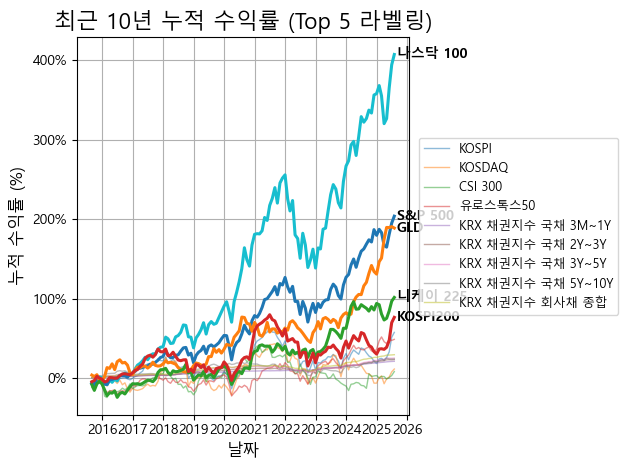

In [6]:
# 마지막 시점 기준 누적 수익률 상위 5개 자산
last_returns = df_cum_return.iloc[-1]
top_assets = last_returns.sort_values(ascending=False).head(5).index
other_assets = [col for col in df_cum_return.columns if col not in top_assets]

# 나머지 자산들 (범례 사용)
for column in other_assets:
    plt.plot(df_cum_return.index, df_cum_return[column], label=column, linewidth=1, alpha=0.5)

# 상위 5개 자산 (직접 라벨링)
for column in top_assets:
    plt.plot(df_cum_return.index, df_cum_return[column], linewidth=2.2)
    last_date = df_cum_return.index[-1]
    last_value = df_cum_return[column].iloc[-1]
    plt.text(last_date + pd.DateOffset(months=1),
             last_value,
             column,
             fontsize=10,
             va='center',
             fontweight='bold')

# y축 퍼센트 형식
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# 그래프 설정
plt.title("최근 10년 누적 수익률 (Top 5 라벨링)", fontsize=16)
plt.xlabel("날짜", fontsize=12)
plt.ylabel("누적 수익률 (%)", fontsize=12)
plt.grid(True)
plt.legend(loc="center left", bbox_to_anchor=(1.01, 0.5), fontsize=9)  # 범례는 나머지용
plt.tight_layout()
plt.show()

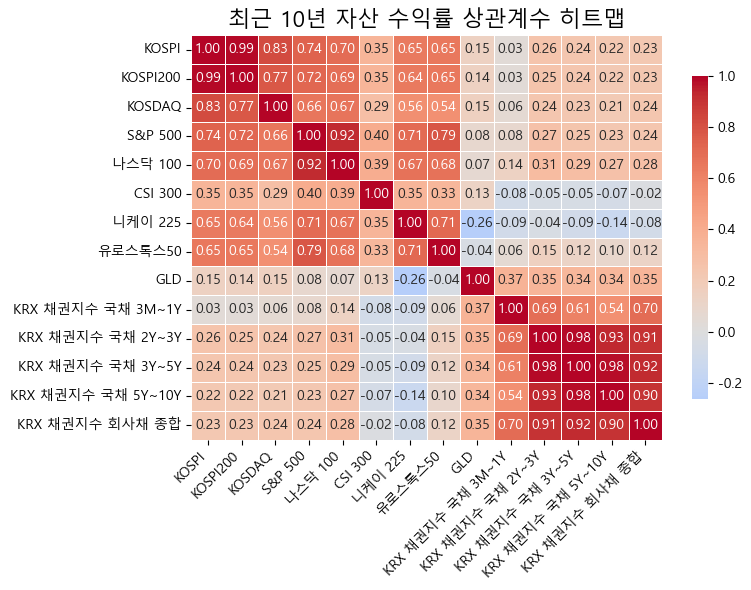

In [7]:
# %%
# ① 공분산 행렬
cov_matrix = df_monthly_return.cov()

# ② 상관계수 행렬
corr_matrix = df_monthly_return.corr()


# %%
try:
    import seaborn as sns
except Exception:
    sns = None
    print('[경고] seaborn 미설치: matplotlib로 대체합니다.')
import matplotlib.pyplot as plt

# 상관계수 행렬 계산
corr_matrix = df_monthly_return.corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("최근 10년 자산 수익률 상관계수 히트맵", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 2. 은퇴설계

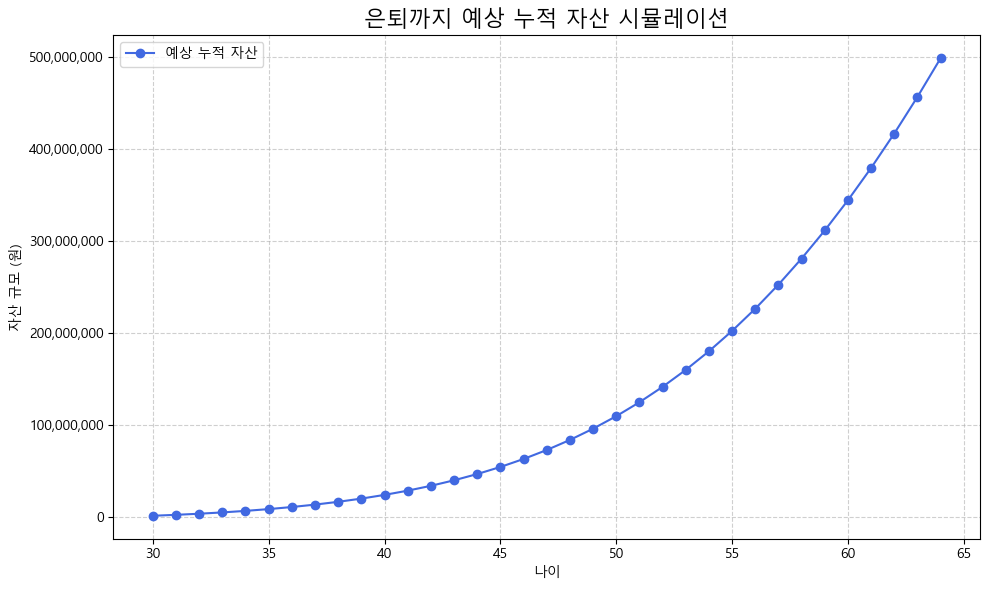


--- 📝 첫 해 기준, 자산별 월 투자금 배분 ---


자산명,비중(%),월 투자금(원)
나스닥 100,39.48%,"26,023원"
GLD,48.81%,"32,173원"
KRX 채권지수 회사채 종합,11.71%,"7,722원"
종합,100.00%,"65,917원"


In [8]:
import pandas as pd
import numpy as np
import cvxpy as cp
import re
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# --- 기존 코드와 동일한 부분 (설정 및 변수 추출) ---

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 파일 경로 (사용자 환경에 맞게 수정 필요)
# 이 코드를 실행하기 전에 'df_monthly_return' 데이터프레임이 미리 정의되어 있어야 합니다.
retirement_file = "손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx"

# 2. 변수 추출
core_df = pd.read_excel(retirement_file, sheet_name='핵심 정보(가정,변수)', header=None)
core_df.columns = ['A', '항목', '값', '비고', 'E']
core_df = core_df[['항목', '값']].dropna()
core_df['값'] = pd.to_numeric(core_df['값'], errors='coerce')
variables = dict(core_df.set_index('항목')['값'])

current_age = int(variables['현재 나이'])
retire_age = int(variables['은퇴 나이'])
retire_years = int(variables['은퇴기간'])
inflation = float(variables['물가상승률(%)'])
gov_pension_monthly = float(variables['공무원연금(월) (현재시점)'])
target_monthly_spending = float(variables['최종 조정 목표 월별 소비금액'])
years_until_retirement = retire_age - current_age

# 3. 투자 성향
survey_df = pd.read_excel(retirement_file, sheet_name='r설문지 응답', header=None)
text_cells = survey_df.astype(str).values.flatten().tolist()
risk_types = ['안정형', '안정추구형', '위험중립형', '적극투자형', '공격투자형']
profile = next((r for cell in text_cells for r in risk_types if r in cell), '위험중립형')
vol_limit_map = {'안정형': 0.05, '안정추구형': 0.07, '위험중립형': 0.10, '적극투자형': 0.13, '공격투자형': 0.16}
target_vol = vol_limit_map[profile]

# 4. 자산 데이터 준비 (df_monthly_return이 정의되어 있다고 가정)
returns = df_monthly_return.dropna()
asset_names = returns.columns
n_assets = len(asset_names)
is_stock = np.array([0 if '채권' in name or '현금' in name else 1 for name in asset_names])

# --- ★★★ 핵심 수정 사항: TDF 로직 수정 ★★★ ---
def tdf_max_stock_ratio(current_year_index, total_years, max_ratio=0.9, min_ratio=0.3):
    """
    올바르게 수정된 TDF 글라이드패스 함수.
    '남은 기간'을 기준으로 주식 비중을 계산합니다.
    """
    # 기간 경과에 따라 주식 비중이 선형으로 감소
    glide_ratio = ((total_years-1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))

# 6. 기대수익률 및 공분산 계산 (EWMA 방식 적용)
span = 60
mu = returns.ewm(span=span).mean().iloc[-1].values * 12
cov = returns.ewm(span=span).cov().iloc[-n_assets:].values * 12

# 7. 연령별 기대수익률 계산
yearly_expected_return = []
yearly_opt_weights = []

# 'i'를 사용하여 투자 진행 연차를 명확히 함
for i in range(years_until_retirement):
    # 수정된 함수 호출
    stock_limit = tdf_max_stock_ratio(i, years_until_retirement)
    w = cp.Variable(n_assets)
    constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov) <= target_vol**2, is_stock @ w <= stock_limit]
    prob = cp.Problem(cp.Maximize(mu @ w), constraints)
    prob.solve()
    
    if w.value is not None:
        yearly_expected_return.append(mu @ w.value)
        yearly_opt_weights.append(w.value)
    else:
        # 최적화 실패 시 안전자산 100%로 설정
        safe_asset_idx = [idx for idx, label in enumerate(classify(name) for name in asset_names) if label == '안전자산'][0]
        w_safe = np.zeros(n_assets)
        w_safe[safe_asset_idx] = 1.0
        yearly_expected_return.append(mu @ w_safe)
        yearly_opt_weights.append(w_safe)

# 8. 필요 은퇴자금 계산
fv_spending = target_monthly_spending * (1 + inflation) ** years_until_retirement
fv_gov_pension = gov_pension_monthly * (1 + inflation) ** years_until_retirement
monthly_gap = max(fv_spending - fv_gov_pension, 0)
total_required = monthly_gap * 12 * retire_years

# 9. 이진 탐색으로 월 투자금 계산
def simulate_retirement_fund(monthly_invest, rate_list):
    fund = 0
    for r in rate_list:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_invest
    return fund

low, high = 1, 10_000_000
while high - low > 1000:
    mid = (low + high) // 2
    if simulate_retirement_fund(mid, yearly_expected_return) > total_required:
        high = mid
    else:
        low = mid
monthly_invest_final = high

# 10. 자산 누적 시뮬레이션 및 시각화
def simulate_asset_path(monthly_invest, rate_list):
    fund = 0
    path = []
    for r in rate_list:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_invest
        path.append(fund)
    return path

asset_path = simulate_asset_path(monthly_invest_final, yearly_expected_return)
ages = list(range(current_age, retire_age))

plt.figure(figsize=(10, 6))
plt.plot(ages, asset_path, label="예상 누적 자산", marker='o', color='royalblue')
plt.xlabel("나이")
plt.ylabel("자산 규모 (원)")
plt.title("은퇴까지 예상 누적 자산 시뮬레이션", fontsize=16)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{x:,.0f}'))
plt.tight_layout()
plt.show()

# 11. 최종 자산 배분 및 월 투자금 요약
final_weights = yearly_opt_weights[0]
amounts_by_asset = final_weights * monthly_invest_final
asset_result = pd.DataFrame({
    '자산명': asset_names,
    '비중(%)': final_weights * 100,
    '월 투자금(원)': amounts_by_asset
})
asset_result = asset_result[asset_result['비중(%)'] > 0.1].round(2)

total_row = pd.DataFrame({
    '자산명': ['종합'],
    '비중(%)': [asset_result['비중(%)'].sum()],
    '월 투자금(원)': [asset_result['월 투자금(원)'].sum()]
})
asset_result = pd.concat([asset_result, total_row], ignore_index=True)

print("\n--- 📝 첫 해 기준, 자산별 월 투자금 배분 ---")
display(asset_result.style.format({'비중(%)': '{:,.2f}%', '월 투자금(원)': '{:,.0f}원'}).hide(axis="index"))



In [9]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# --- 1. 이전 셀에서 계산된 변수들이 필요합니다 ---
# 이 코드를 실행하기 전에 mu, cov, target_vol, years_until_retirement, 
# ages, asset_names, tdf_max_stock_ratio 함수 등이 정의되어 있어야 합니다.

# --- 2. 연령별 기대수익률 + 포트폴리오 기록용 테이블 생성 (수정된 로직) ---
yearly_stock_limit = []
yearly_target_vol = []
yearly_portfolio_vol = []
yearly_expected_return = []
yearly_opt_weights = []

# 'i'를 사용하여 투자 진행 연차를 명확히 함
for i in range(years_until_retirement):
    # ★★★ 올바른 함수 호출 방식으로 수정 ★★★
    stock_limit = tdf_max_stock_ratio(i, years_until_retirement)
    
    w = cp.Variable(n_assets)
    constraints = [
        cp.sum(w) == 1,
        w >= 0,
        cp.quad_form(w, cov) <= target_vol**2,
        is_stock @ w <= stock_limit
    ]
    prob = cp.Problem(cp.Maximize(mu @ w), constraints)
    prob.solve()

    if w.value is not None:
        w_opt = w.value
        r = mu @ w_opt
        vol = np.sqrt(w_opt @ cov @ w_opt)
    else:
        # 최적화 실패 시 안전자산 100%로 설정
        safe_asset_idx = [idx for idx, label in enumerate(classify(name) for name in asset_names) if label == '안전자산'][0]
        w_opt = np.zeros(n_assets)
        w_opt[safe_asset_idx] = 1.0
        r = mu @ w_opt
        vol = np.sqrt(w_opt @ cov @ w_opt)

    yearly_stock_limit.append(stock_limit)
    yearly_target_vol.append(target_vol)
    yearly_expected_return.append(r)
    yearly_portfolio_vol.append(vol)
    yearly_opt_weights.append(w_opt)

# --- 3. 기대수익률 테이블 만들기 ---
table_df = pd.DataFrame({
    '나이': ages,
    '주식 상한(%)': np.round(np.array(yearly_stock_limit) * 100, 1),
    '변동성 제한(%)': np.round(np.array(yearly_target_vol) * 100, 1),
    '기대수익률(%)': np.round(np.array(yearly_expected_return) * 100, 2),
    '포트폴리오 변동성(%)': np.round(np.array(yearly_portfolio_vol) * 100, 2)
})

print("\n--- 📋 연령별 투자 전략 요약 테이블 ---")
# display 함수는 Jupyter Notebook 환경에서 표를 예쁘게 보여줍니다.
display(table_df.style.format("{:,.2f}"))




--- 📋 연령별 투자 전략 요약 테이블 ---


,나이,주식 상한(%),변동성 제한(%),기대수익률(%),포트폴리오 변동성(%)
0,30.00,88.30,10.00,17.55,10.00
1,31.00,86.60,10.00,17.33,10.00
2,32.00,84.90,10.00,17.11,10.00
3,33.00,83.10,10.00,16.87,10.00
4,34.00,81.40,10.00,16.63,10.00
5,35.00,79.70,10.00,16.39,10.00
6,36.00,78.00,10.00,16.15,10.00
7,37.00,76.30,10.00,15.91,10.00
8,38.00,74.60,10.00,15.66,10.00
9,39.00,72.90,10.00,15.41,10.00


C:\Users\tjw71\AppData\Local\Temp\ipykernel_31900\2458912336.py:32: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.tight_layout()
c:\Users\tjw71\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


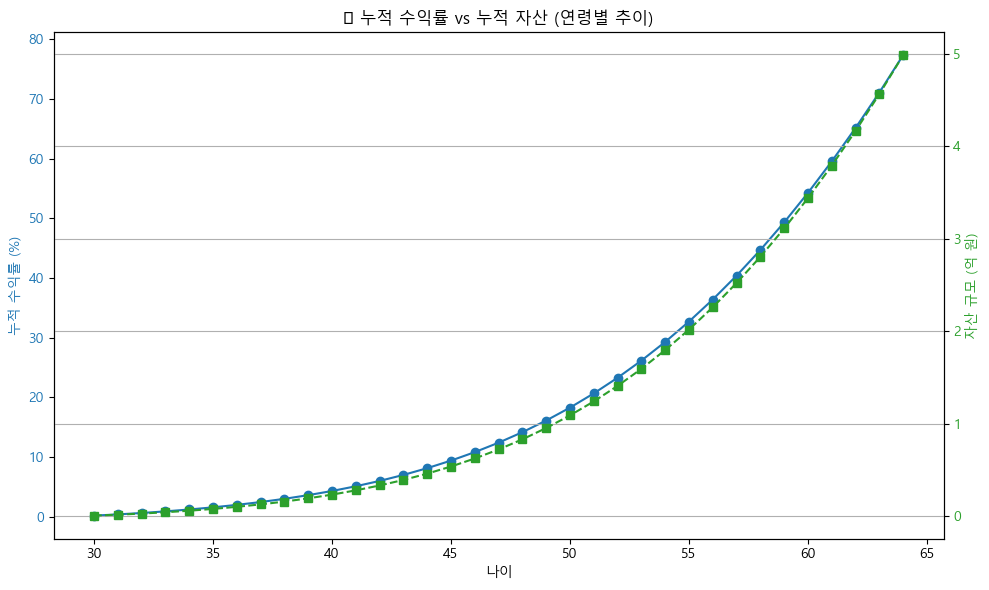

In [10]:
import matplotlib.pyplot as plt

# 누적 수익률 계산
cumulative_returns = []
cumulative = 1.0
for r in yearly_expected_return[:len(asset_path)]:  # 길이 맞춤
    cumulative *= (1 + r)
    cumulative_returns.append(cumulative - 1)

# 나이 리스트 (자산 경로와 동일한 길이로 설정)
ages = list(range(current_age, current_age + len(asset_path)))

# 시각화
fig, ax1 = plt.subplots(figsize=(10, 6))

# 좌측 y축: 누적 수익률 (%)
color1 = 'tab:blue'
ax1.set_xlabel("나이")
ax1.set_ylabel("누적 수익률 (%)", color=color1)
ax1.plot(ages, [r for r in cumulative_returns], marker='o', color=color1, label="누적 수익률")
ax1.tick_params(axis='y', labelcolor=color1)

# 우측 y축: 자산 규모 (억 원 단위)
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel("자산 규모 (억 원)", color=color2)
ax2.plot(ages, [a / 100_000_000 for a in asset_path], marker='s', linestyle='--', color=color2, label="누적 자산")
ax2.tick_params(axis='y', labelcolor=color2)

# 제목 및 그리드
plt.title("📈 누적 수익률 vs 누적 자산 (연령별 추이)")
fig.tight_layout()
plt.grid(True)
plt.show()


--- 📋 연령별 상세 자산 배분 계획표 (%) ---


,나스닥 100,GLD,KRX 채권지수 회사채 종합
30,39.5%,48.8%,11.7%
31,41.7%,44.9%,13.4%
32,43.3%,41.6%,15.1%
33,44.6%,38.6%,16.9%
34,45.6%,35.8%,18.6%
35,46.5%,33.2%,20.3%
36,47.2%,30.8%,22.0%
37,47.8%,28.5%,23.7%
38,48.4%,26.2%,25.4%
39,48.8%,24.0%,27.1%


c:\Users\tjw71\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


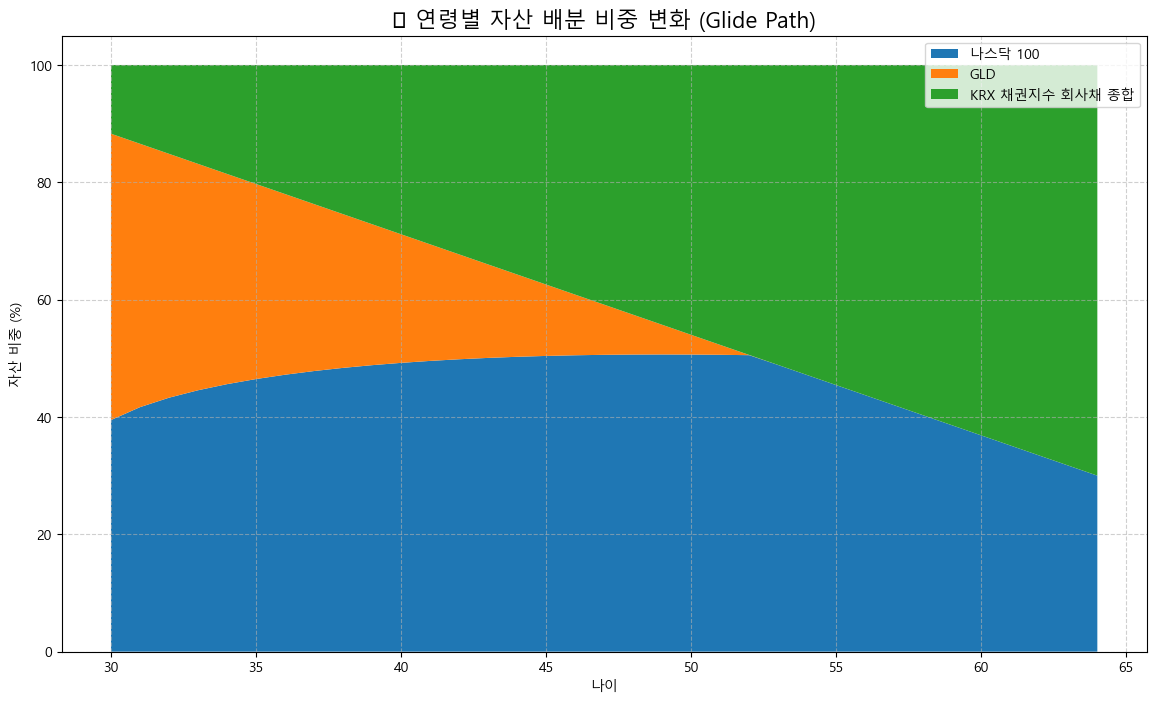

In [11]:
# --- 2. 연도별 포트폴리오 상세 계획표 생성 ---

# 연령별 최적 비중을 DataFrame으로 변환
weights_df = pd.DataFrame(yearly_opt_weights, index=ages, columns=asset_names)

# 비중이 0.1% 이상이었던 자산만 필터링하여 보기 쉽게 만듭니다.
weights_df = weights_df.loc[:, (weights_df > 0.001).any(axis=0)]
weights_df *= 100 # 백분율로 변환

print("\n--- 📋 연령별 상세 자산 배분 계획표 (%) ---")
display(weights_df.style.format("{:,.1f}%"))


# --- 3. 스택형 영역 차트로 시각화 ---

plt.figure(figsize=(14, 8))
plt.stackplot(weights_df.index, weights_df.T, labels=weights_df.columns)
plt.legend(loc='upper right')
plt.title('📈 연령별 자산 배분 비중 변화 (Glide Path)', fontsize=16)
plt.xlabel('나이')
plt.ylabel('자산 비중 (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


## 3. 종합 설계

### 3-1. 재무목표 도출

In [ ]:
# --- 파일 경로 정의 ---
# 각 엑셀 파일의 실제 위치에 맞게 경로를 수정해주세요.
household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'
# 'r설문지 응답' 시트가 포함된 원본 엑셀 파일의 경로를 지정해야 합니다.
# (업로드된 파일 목록에서는 이 파일의 원본 .xlsx가 아닌 CSV만 확인되므로,
# 실제 실행 환경에 원본 파일이 있다고 가정하고 경로를 작성했습니다.)
retirement_model_file_path = '손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx'

try:
    # --- 데이터 추출 ---

    # 1. 가계부 엑셀 파일에서 정보 가져오기
    # 파일: 손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm
    # 시트: 뱅샐현황
    df_household = pd.read_excel(household_file_path, sheet_name='뱅샐현황', header=None, engine='openpyxl')
    
    # iloc[row, column]를 사용하여 특정 셀 값 추출 (0부터 시작)
    age = df_household.iloc[5, 3]      # D6 셀
    gender = df_household.iloc[5, 2]   # C6 셀
    credit_score = df_household.iloc[5, 4] # E6 셀


    # 2. 은퇴설계 모델 엑셀 파일에서 직업 정보 가져오기
    # 파일: 손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx
    # 시트: r설문지 응답
    # 엑셀의 특정 시트를 직접 읽도록 수정했습니다.
    df_retirement_survey = pd.read_excel(retirement_model_file_path, sheet_name='r설문지 응답', header=None)

    # C12 셀에 해당하는 데이터 추출
    job = df_retirement_survey.iloc[11, 3] # C열(2), 12번째 행(11)


    # --- client_profile 딕셔너리 생성 ---
    
    client_profile = {
        "고객정보": {
            "고객명": "넉넉한 윤리쌤",
            "나이": age,
            "직업": job,
            "성별": gender,
            "신용점수": credit_score
        }
    }

    # --- 결과 확인 ---
    print("✅ '고객정보' 생성이 완료되었습니다. (수정 완료)")
    
    import json
    print(json.dumps(client_profile, ensure_ascii=False, indent=4))

except FileNotFoundError as e:
    # 사용자가 원본 .xlsx 파일을 업로드하지 않았을 경우를 대비한 안내
    print(f"오류: 파일을 찾을 수 없습니다.")
    print(f"지정한 경로에 '{e.filename}' 파일이 있는지 확인해주세요.")
    print("특히 '손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx' 파일이 필요합니다.")
    
except ValueError as e:
    # 엑셀에 해당 시트가 없을 경우 발생하는 오류 처리
    if "Worksheet" in str(e) and "not found" in str(e):
        print(f"오류: 엑셀 파일 안에 '{retirement_model_file_path}' 시트가 없습니다. 시트 이름을 확인해주세요.")
    else:
        print(f"데이터를 읽는 중 오류가 발생했습니다: {e}")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd

# --- 이전 단계 코드 실행으로 client_profile이 생성되어 있다고 가정합니다. ---
# 만약 이 스크립트를 단독으로 실행한다면, 아래 주석을 해제하여 client_profile을 생성해주세요.
# client_profile = {"고객정보": {}}


# --- 파일 경로 정의 ---
household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'

try:
    # --- 데이터 불러오기 및 전처리 ---
    df = pd.read_excel(household_file_path, sheet_name='가계부 내역', engine='openpyxl')
    
    # '거래일' 컬럼을 날짜 형식으로 변환 (오류 발생 시 무시)
    df['거래일'] = pd.to_datetime(df['거래일'], errors='coerce')
    # 날짜 형식이 아닌 데이터 제거
    df.dropna(subset=['거래일'], inplace=True)

    # --- 분석 기준월('이번 달') 결정 ---
    latest_date = df['거래일'].max()
    # is_month_end는 해당 월의 마지막 날인지 확인하는 pandas 기능입니다.
    if latest_date.is_month_end:
        analysis_month_period = pd.Period(latest_date, freq='M')
    else:
        # 월말이 아니면, 한 달을 뺀다.
        analysis_month_period = pd.Period(latest_date, freq='M') - 1
    
    print(f"알림: 데이터의 최근 날짜는 {latest_date.strftime('%Y-%m-%d')} 입니다.")
    print(f"알림: 분석 기준월('이번 달')은 '{analysis_month_period.strftime('%Y년 %m월')}' 입니다.")

    # --- 최근 3개월간 월별 데이터 계산 ---
    monthly_summary = []
    for i in range(3):
        target_month = analysis_month_period - i
        
        # 해당 월의 데이터 필터링
        df_month = df[df['거래일'].dt.to_period('M') == target_month]

        # 1. 수입 계산
        income = df_month[df_month['pv_대분류'] == '수입']['pv_지출액'].sum()
        
        # 2. 지출 계산 (지출 - 이체)
        spend_total = df_month[df_month['pv_대분류'] == '지출']['pv_지출액'].sum()
        transfer_total = df_month[df_month['pv_대분류'] == '이체']['pv_지출액'].sum()
        expenditure = spend_total + transfer_total
        
        # 3. 저축/투자 계산
        investment = df_month[df_month['pv_대분류'] == '저축/투자']['pv_지출액'].sum()

        # 4. 현금(여윳돈)
        cash_surpuls = income - (expenditure + investment)

        monthly_summary.append({
            "month": target_month,
            "income": income,
            "expenditure": expenditure,
            "investment": investment,
            "cash_surpuls" : cash_surpuls
        })

    # --- 최종 지표 계산 ---
    # 1) ~ 4) '이번 달' 현황
    this_month_data = monthly_summary[0]
    this_month_income = this_month_data['income']
    this_month_expenditure = this_month_data['expenditure']
    this_month_investment = this_month_data['investment']


    # 현금(여윳돈) = 수입 - (지출 + 저축/투자)
    this_month_cash_surplus = this_month_income - (this_month_expenditure + this_month_investment)

    # 5) ~ 8) 3개월 평균 현황
    avg_income = sum(item['income'] for item in monthly_summary) / 3
    avg_expenditure = sum(item['expenditure'] for item in monthly_summary) / 3
    avg_investment = sum(item['investment'] for item in monthly_summary) / 3
    avg_cash_surpuls = sum(item['cash_surpuls'] for item in monthly_summary) / 3

    # 평균 순수입 = 평균 수입 - 평균 지출
    avg_net_income = avg_income - avg_expenditure

    # --- client_profile 딕셔너리에 추가 ---
    client_profile['수입/지출/투자 현황'] = {
        "분석 기준월": analysis_month_period.strftime('%Y-%m'),
        "이번 달 수입": f"{this_month_income:,.0f}원",
        "이번 달 지출": f"{this_month_expenditure:,.0f}원",
        "이번 달 저축/투자": f"{this_month_investment:,.0f}원",
        "이번 달 현금(여윳돈)": f"{this_month_cash_surplus:,.0f}원",
        "최근 3개월 평균 수입": f"{avg_income:,.0f}원",
        "최근 3개월 평균 지출": f"{avg_expenditure:,.0f}원",
        "최근 3개월 평균 순수입": f"{avg_net_income:,.0f}원",
        "최근 3개월 평균 저축/투자": f"{avg_investment:,.0f}원",
        "최근 3개월 평균 현금(여윳돈)" : f"{avg_cash_surpuls:,.0f}원"
    }

    # --- 결과 확인 ---
    print("\n✅ '수입/지출/투자 현황' 생성이 완료되었습니다.")
    import json
    print(json.dumps(client_profile, ensure_ascii=False, indent=4))

except FileNotFoundError:
    print(f"오류: '{household_file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
except KeyError as e:
    print(f"오류: 엑셀 시트에서 필요한 컬럼({e})을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd

# --- 이전 단계 코드 실행으로 client_profile, df, analysis_month_period 변수가 생성되어 있다고 가정합니다. ---

try:
    # --- 최종 데이터를 담을 딕셔너리 초기화 ---
    monthly_cash_flow_final = {}

    # --- 최근 6개월간 월별로 데이터 처리 ---
    for i in range(6):
        # 역순으로 6개월간의 월을 하나씩 가져옴 (예: 5월 -> 4월 -> 3월...)
        target_month_period = analysis_month_period - i
        month_str = target_month_period.strftime('%Y-%m')
        
        # 해당 월의 데이터만 필터링
        df_month = df[df['거래일'].dt.to_period('M') == target_month_period]

        # --- 1. 대분류별 총합 계산 ---
        income_total = df_month[df_month['pv_대분류'] == '수입']['pv_지출액'].sum()
        spend_total = df_month[df_month['pv_대분류'] == '지출']['pv_지출액'].sum()
        transfer_total = df_month[df_month['pv_대분류'] == '이체']['pv_지출액'].sum()
        investment_total = df_month[df_month['pv_대분류'] == '저축/투자']['pv_지출액'].sum()

        # --- 2. 중분류 상세 내역 계산 ---
        income_details = df_month[df_month['pv_대분류'] == '수입'].groupby('pv_중분류')['pv_지출액'].sum().to_dict()
        spend_details = df_month[df_month['pv_대분류'].isin(['지출', '이체'])].groupby('pv_중분류')['pv_지출액'].sum().to_dict()
        investment_details = df_month[df_month['pv_대분류'] == '저축/투자'].groupby('pv_중분류')['pv_지출액'].sum().to_dict()

        # --- 3. 해당 월의 최종 데이터 구조 조립 ---
        month_data = {
            "수입": {
                "총합": income_total,
                "상세내역": {k: v for k, v in sorted(income_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "총지출(이체포함)": {
                "총합": spend_total + transfer_total,
                "상세내역": {k: v for k, v in sorted(spend_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "저축/투자": {
                "총합": investment_total,
                "상세내역": {k: v for k, v in sorted(investment_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
            },
            "순현금흐름(여윳돈)": income_total - (spend_total + transfer_total + investment_total)
        }
        
        # --- 4. [특별 처리] '이번 달'에만 '소분류' 데이터 추가 ---
        if target_month_period == analysis_month_period:
            # '총지출(이체포함)'의 중분류 항목들에 대해 소분류 내역 추가
            spend_details_with_small = {}
            for mid_category, mid_total in month_data["총지출(이체포함)"]["상세내역"].items():
                small_category_details = df_month[df_month['pv_중분류'] == mid_category] \
                                         .groupby('pv_소분류')['pv_지출액'].sum().to_dict()
                
                spend_details_with_small[mid_category] = {
                    "총합": mid_total,
                    "소분류 상세": {k: v for k, v in sorted(small_category_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
                }
            # 기존 상세내역을 소분류가 포함된 상세내역으로 교체
            month_data["총지출(이체포함)"]["상세내역"] = spend_details_with_small
        
            # [수정된 부분] '저축/투자'의 중분류 항목들에 대해 소분류 내역 추가
            investment_details_with_small = {}
            if month_data["저축/투자"]["상세내역"]:
                for mid_category, mid_total in month_data["저축/투자"]["상세내역"].items():
                    small_category_details = df_month[
                        (df_month['pv_대분류'] == '저축/투자') &
                        (df_month['pv_중분류'] == mid_category)
                    ].groupby('pv_소분류')['pv_지출액'].sum().to_dict()

                    investment_details_with_small[mid_category] = {
                        "총합": mid_total,
                        "소분류 상세": {k: v for k, v in sorted(small_category_details.items(), key=lambda item: item[1], reverse=True) if v > 0}
                    }
                # 기존 상세내역을 소분류가 포함된 상세내역으로 교체
                month_data["저축/투자"]["상세내역"] = investment_details_with_small
        
        # 최종 딕셔너리에 해당 월의 데이터를 추가
        monthly_cash_flow_final[month_str] = month_data


    # --- client_profile 딕셔너리에 추가 ---
    # 월별로 정렬하여 최종 저장
    client_profile['월별 현금흐름 요약'] = dict(sorted(monthly_cash_flow_final.items()))

    # --- 결과 확인 ---
    print("\n✅ '월별 현금흐름 요약 (최종 수정 버전)' 생성이 완료되었습니다.")
    
    import json
    # 전체 6개월 데이터가 모두 포함된 것을 확인
    print(json.dumps(client_profile['월별 현금흐름 요약'], ensure_ascii=False, indent=4, default=str))

except NameError as e:
    print(f"오류: 이전 단계의 변수({e})가 필요합니다. 이전 코드들을 먼저 실행해주세요.")
except KeyError as e:
    print(f"오류: 엑셀 시트에서 필요한 컬럼({e})을 찾을 수 없습니다. 컬럼명을 확인해주세요.")
except Exception as e:
    print(f"데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: {e}")

# %%
import pandas as pd
import numpy as np

# --- 이전 단계 코드 실행으로 client_profile이 생성되어 있다고 가정합니다. ---

try:
    # --- 1. 데이터 불러오기 및 동적 범위 탐색 ---
    household_file_path = '손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm'
    df = pd.read_excel(household_file_path, sheet_name='뱅샐현황', header=None, engine='openpyxl')
    
    col_b = df.iloc[:, 1].astype(str)
    start_row_series = col_b[col_b.str.contains("자유입출금 자산", na=False)]
    end_row_series = col_b[col_b.str.contains("연금 자산", na=False)]

    if start_row_series.empty or end_row_series.empty:
        raise ValueError("자산/부채 테이블의 시작('자유입출금 자산') 또는 끝('연금 자산') 위치를 찾을 수 없어 중단합니다.")
    
    start_row = start_row_series.index[0]
    end_row = end_row_series.index[0]

    # --- 2. 데이터 테이블 슬라이싱 및 전처리 ---
    df_table = df.iloc[start_row:end_row + 1].copy()
    df_table.iloc[:, 1] = df_table.iloc[:, 1].ffill() # 자산 중분류 병합 처리
    df_table.iloc[:, 5] = df_table.iloc[:, 5].ffill() # 부채 중분류 병합 처리

    # --- 3. 자산/부채 상세 데이터 구조화 ---
    assets_dict = {}
    liability_dict = {}

    # 자산 처리 (B, C, E 열)
    asset_data = df_table[[1, 2, 4]].dropna(subset=[2])
    for index, row in asset_data.iterrows():
        mid_category, product_name, amount_raw = row[1], row[2], row[4]
        amount = pd.to_numeric(amount_raw, errors='coerce')
        if pd.notna(amount) and amount > 0:
            assets_dict.setdefault(mid_category, {})[product_name] = amount

    # 부채 처리 (F, G, I 열)
    liability_data = df_table[[5, 6, 8]].dropna(subset=[6])
    for index, row in liability_data.iterrows():
        mid_category, product_name, amount_raw = row[5], row[6], row[8]
        amount = pd.to_numeric(amount_raw, errors='coerce')
        if pd.notna(amount) and amount > 0:
            liability_dict.setdefault(mid_category, {})[product_name] = amount

    # --- 4. [핵심 수정] 상세 내역을 합산하여 총계 계산 ---
    # 각 중분류 딕셔너리의 모든 금액(value)들을 합산
    total_assets_val = sum(sum(v.values()) for v in assets_dict.values())
    total_liability_val = sum(sum(v.values()) for v in liability_dict.values())
    net_assets_val = total_assets_val - total_liability_val

    # --- 5. client_profile에 최종 데이터 추가 ---
    client_profile['자산/부채 현황'] = {
        "총자산": total_assets_val,
        "총부채": total_liability_val,
        "순자산": net_assets_val,
        "자산 상세": assets_dict,
        "부채 상세": liability_dict
    }
    
    # --- 결과 확인 ---
    print("\n✅ '자산/부채 현황' 생성이 완료되었습니다. (총계 계산 로직 수정)")
    
    import json
    print(json.dumps(client_profile['자산/부채 현황'], ensure_ascii=False, indent=4, default=str))

except ValueError as e:
    print(f"오류: {e}")
except Exception as e:
    print(f"데이터 처리 중 예상치 못한 오류가 발생했습니다. 엑셀 파일의 구조나 내용을 확인해주세요.")
    print(f"오류 상세: {e}")


def extract_survey_answers(df):
    answers = {}
    for _, row in df.iterrows():
        question = str(row[2]).strip()
        response = str(row[3]).strip()
        if question and response and response.lower() != "nan":
            answers[question] = response
    return answers

# --- 메인 실행 함수 ---
def generate_client_inputs(retirement_path, budget_path):
    df_core = pd.read_excel(retirement_path, sheet_name="핵심 정보(가정,변수)", header=None)
    age = int(df_core.iloc[4, 2])
    retire_age = int(df_core.iloc[5, 2])
    years_to_retire = retire_age - age
    
    df_banksalad_status = pd.read_excel(budget_path, sheet_name="뱅샐현황", header=None)
    df_banksalad_status = df_banksalad_status.dropna(how='all', axis=0).dropna(how='all', axis=1)
    df_banksalad_status = df_banksalad_status.fillna('')

    df_survey_raw = pd.read_excel(retirement_path, sheet_name="r설문지 응답", header=None)
    survey = extract_survey_answers(df_survey_raw)

    profile = {
        "age": age,
        "retirement_age_target": retire_age,
        "years_to_retire": years_to_retire,
        
    }

    return profile, survey

# --- 실행 ---
retirement_file = "손PB_은퇴설계 모델_250510_v1.1_탁지원.xlsx"
budget_file = "손PB_넉넉한 윤리쌤_가계부_2507022_v1.3_탁지원.xlsm"
survey_answers = generate_client_inputs(retirement_file, budget_file)

# --- 결과 확인 ---
print("✅ 최종 고객 프로필 (구조화된 데이터):")
client_profile

print("\n\n✅ 설문조사 응답:")
print(json.dumps(survey_answers, indent=2, ensure_ascii=False))

데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: name 'pd' is not defined
알림: 데이터의 최근 날짜는 2025-06-07 입니다.
알림: 분석 기준월('이번 달')은 '2025년 05월' 입니다.
데이터를 처리하는 중 예상치 못한 오류가 발생했습니다: name 'client_profile' is not defined
오류: 이전 단계의 변수(name 'client_profile' is not defined)가 필요합니다. 이전 코드들을 먼저 실행해주세요.
데이터 처리 중 예상치 못한 오류가 발생했습니다. 엑셀 파일의 구조나 내용을 확인해주세요.
오류 상세: name 'client_profile' is not defined
✅ 최종 고객 프로필 (구조화된 데이터):


NameError: name 'client_profile' is not defined

In [13]:
# %%
# 은퇴 목표 정보 구성 (GPT용)
retirement_goal_description = f"""
- 은퇴 목표 시점: 만 {retire_age}세
- 은퇴 기간: {retire_years}년
- 목표 생활비: 월 {int(target_monthly_spending):,}원
- 예상 총 필요 은퇴자금: 약 {int(total_required):,}원
- 예상 연금 수령: 월 {int(gov_pension_monthly):,}원
- 시뮬레이션 기반 투자 계획: 월 {int(monthly_invest_final):,}원씩 투자 필요
"""
print(retirement_goal_description)



- 은퇴 목표 시점: 만 65세
- 은퇴 기간: 35년
- 목표 생활비: 월 2,500,000원
- 예상 총 필요 은퇴자금: 약 496,529,103원
- 예상 연금 수령: 월 2,000,000원
- 시뮬레이션 기반 투자 계획: 월 65,917원씩 투자 필요



In [14]:
import openai
import ast
import re
import json
import os

# ==============================================================================
# ⭐️ 1. AI 응답 검증 및 정규화 함수 (수정된 버전)
# ==============================================================================
def validate_and_normalize_goals(parsed_list, source_ai_version="1차"):
    """
    AI가 생성한 목표 리스트를 검증하고, 백테스팅에 사용할 수 있는
    표준 형식({'name', 'years', 'target', 'priority', 'necessity'})으로 변환합니다.
    """
    cleaned_goal_list = []
    
    def extract_years(time_frame_value):
        if isinstance(time_frame_value, (int, float)): return int(time_frame_value)
        if isinstance(time_frame_value, str):
            numbers = re.findall(r'\d+', time_frame_value)
            return int(numbers[0]) if numbers else None
        return None

    for item in parsed_list:
        name = item.get('name') or item.get('목표명')
        target = item.get('target') or item.get('goal_amount')
        time_value = item.get('time_frame') or item.get('years')
        years = extract_years(time_value)
        
        # ⭐️ 중요: 우선순위와 필수성 정보를 반드시 가져오도록 수정
        priority = item.get('priority')
        necessity = item.get('necessity')

        # 1차 AI 응답에서는 모든 정보가 필수입니다.
        if not all([name, target, years, priority, necessity]):
            print(f"⚠️ 경고 ({source_ai_version} AI): '{name or '이름 없는'}' 목표에서 필수 정보(이름, 금액, 기간, 우선순위, 필수성)가 누락/유효하지 않아 제외합니다.")
            continue
            
        cleaned_goal_list.append({
            'name': name, 
            'years': int(years), 
            'target': int(target), 
            'is_short_term': int(years) <= 1,
            'priority': priority, 
            'necessity': necessity
        })
    return cleaned_goal_list

In [15]:
GOAL_LIST_SCHEMA = {
    "name": "goal_list_v1",
    "schema": {
        "type": "object",
        "additionalProperties": False,
        "properties": {
            "goals": {
                "type": "array",
                "items": {
                    "type": "object",
                    "additionalProperties": False,
                    "properties": {
                        "name":       {"type": "string", "description": "목표 이름"},
                        "years":      {"type": "integer", "minimum": 1, "maximum": 50, "description": "달성까지 남은 연수"},
                        "target":     {"type": "integer", "minimum": 0, "description": "목표 금액(원)"},
                        "priority":   {"type": "integer", "minimum": 1, "maximum": 5, "description": "우선순위(1=최상)"},
                        "necessity":  {"type": "string", "enum": ["필수","선택"], "description": "필수 여부"}
                    },
                    "required": ["name","years","target","priority","necessity"]
                }
            }
        },
        "required": ["goals"]
    },
    "strict": True
}

# ==============================================================================
# 2. 메인 실행 로직 (기존과 동일하되, LLM 호출/파싱만 교체)
# ==============================================================================
cache_file_path = "financial_goals_cache.json"
goal_list = []

if os.path.exists(cache_file_path):
    print(f"✅ 캐시 파일({cache_file_path})을 발견했습니다. API 호출 없이 데이터를 불러옵니다.")
    with open(cache_file_path, 'r', encoding='utf-8') as f:
        goal_list = json.load(f)
else:
    print(f"ℹ️ 캐시 파일이 없습니다. OpenAI API를 호출하여 재무 목표를 생성합니다.")
    
    savings_capacity = avg_cash_surpuls  # 기존 변수 그대로 사용

    # ✅ 스키마 필드명에 맞춘 지시 (중괄호 이스케이프 주의!)
    system_prompt = f"""
    당신은 FPSB 공인 CFP 자격을 보유한 재무설계 전문가이며, 고객 재무목표 설계 알고리즘을 위한 전문가 자문 역할을 수행합니다.

    **[최상위 제약]**
    - 모든 재무 목표를 달성하기 위한 월 필요 저축액의 총합은 고객의 월 저축/투자 가능 금액인 {savings_capacity:,.0f}원을 절대 초과하지 않아야 합니다.

    **[출력 형식(중요)]**
    - 아래 스키마에 '정확히' 맞춰 **객체**를 출력하세요. 추가 키 금지.
    - 최상위는 {{\"goals\": [...]}} 형태이며, goals는 다음 항목들의 배열입니다:
    {{name:str, years:int, target:int, priority:int(1~5), necessity:\"필수\"|\"선택\"}}

    **[세부 수행 지침]**
    1. 고객의 재무상태, 생애주기, 소득수준, 소비/부채 구조, 투자성향 및 재무지식 수준을 종합 분석.
    2. CFP 국제 기준 및 한국형 실무 원칙에 따라 필요한 재무목표들을 도출.
    3. 각 목표는 다음 필드를 사용:
    - name: 목표 이름
    - years: 목표 달성까지 남은 연수(정수, 년 단위)
    - target: 목표 금액(원, 정수)
    - priority: 1~5 (1이 최상)
    - necessity: "필수" 또는 "권장"
    4. 고객이 직접 제시한 목표가 있어도, **월 {savings_capacity:,.0f}원** 한도 내 달성이 가능하도록 금액/기간을 조정(근거는 내부적으로 고려하되 출력에는 포함하지 않음).
    5. 1/3/5/10년 등 일반 저축 목표는 고객의 소득/지출 구조를 반영한 현실적 권고 수준으로 설정.
    6. 재무건전성/유동성/생애주기를 반영해 합리적 우선순위 부여.
    7. 아래 '은퇴 관련 목표 정보'는 내용 수정 없이 **중요도 판단만 반영**.

    **[응답 규칙]**
    - 설명 문장, 마크다운, 코드블록, 주석 없이 **JSON 객체만** 출력.
    - 최상위에 "goals" 배열을 포함할 것.
    - 스키마에 정의되지 않은 키는 절대 포함하지 말 것.
    """


    user_prompt = f"""
    [고객 프로필 정보]\n{client_profile}\n
    [설문 응답 정보]\n{survey_answers}\n
    [은퇴 관련 목표 정보]\n{retirement_goal_description}
    """

    try:
        # ✅ 키 하드코딩 금지: 환경변수 사용 권장 (예: OPENAI_API_KEY)
        client = openai.OpenAI()  

        # ✅ 구조화 출력: 스키마 강제
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            temperature=0.5,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            response_format={"type": "json_schema", "json_schema": GOAL_LIST_SCHEMA}
        )

        raw_json = response.choices[0].message.content
        parsed = json.loads(raw_json)
        goal_list = parsed["goals"]  # ← 래퍼에서 goals만 꺼냄


        # (선택) 후속 검증/보정 훅: 기존 함수를 슬림화해서 유지하고 싶다면 아래 라인 주석 해제
        # goal_list = validate_and_normalize_goals(goal_list, source_ai_version="구조화")

        # 캐시 저장
        if goal_list:
            with open(cache_file_path, 'w', encoding='utf-8') as f:
                json.dump(goal_list, f, ensure_ascii=False, indent=4)
            print(f"\n✅ 구조화 응답을 '{cache_file_path}' 파일에 저장했습니다.")
        else:
            print("\n⚠️ 유효한 재무 목표가 비어 있습니다.")

    except Exception as e:
        print(f"\n⚠️ API 호출 또는 파싱 중 오류가 발생했습니다: {e}")

if goal_list:
    print("\n✅ 최종 생성된 재무 목표 'goal_list':")
    print(goal_list)
else:
    print("\n⚠️ 'goal_list'가 생성되지 않았습니다. API 응답 또는 캐시 파일을 확인해주세요.")


✅ 캐시 파일(financial_goals_cache.json)을 발견했습니다. API 호출 없이 데이터를 불러옵니다.

✅ 최종 생성된 재무 목표 'goal_list':
[{'name': '단기 저축 목표', 'years': 5, 'target': 59622052, 'priority': 2, 'necessity': '필수'}, {'name': '은퇴 자금 마련', 'years': 35, 'target': 496529103, 'priority': 1, 'necessity': '필수'}]


In [16]:
import pandas as pd
import numpy as np
import cvxpy as cp
from copy import deepcopy

# --- 1. 설정 및 헬퍼 함수 정의 ---

def get_unified_stock_limit(total_years, current_year_index):
    """모든 목표에 동일한 TDF 글라이드패스 로직을 적용합니다."""
    max_ratio, min_ratio = 0.9, 0.3
    glide_ratio = ((total_years-1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))

def get_expected_return_path(goal):
    """지정된 목표에 대한 연간 기대수익률 경로를 계산합니다."""
    yearly_expected_return = []
    for i in range(goal['years']):
        stock_limit = get_unified_stock_limit(goal['years'], i)
        w = cp.Variable(n_assets)
        constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov) <= target_vol**2, is_stock @ w <= stock_limit]
        prob = cp.Problem(cp.Maximize(mu @ w), constraints)
        prob.solve()
        yearly_expected_return.append(mu @ w.value if w.value is not None else 0.04)
    return yearly_expected_return

def calculate_monthly_investment(target_amount, yearly_return_rates, initial_fund=0):
    if target_amount <= 0:
        return 0
        
    def simulate_fund(monthly_invest, rate_list, start_fund):
        fund = start_fund
        for r in rate_list:
            for _ in range(12):
                fund = fund * (1 + r / 12) + monthly_invest
        return fund
    low, high = 0, 10_000_000
    while high - low > 1000:
        mid = (low + high) // 2
        if simulate_fund(mid, yearly_return_rates, initial_fund) > target_amount:
            high = mid
        else:
            low = mid
    return high

def simulate_final_asset(monthly_investment, yearly_return_rates, initial_fund=0):
    fund = initial_fund
    for r in yearly_return_rates:
        for _ in range(12):
            fund = fund * (1 + r / 12) + monthly_investment
    return fund

# --- 2. 메인 실행 로직 (수정된 버전) ---

# 2-1. 1차 분석: 각 목표별 필요 월 투자금 계산
print("--- 💡 1차 분석: 재무 목표별 월 필요 투자금 ---")
goal_summary_list = []
if 'goal_list' in locals() and goal_list:
    for goal in goal_list:
        yearly_return_rates = get_expected_return_path(goal)
        monthly_investment = calculate_monthly_investment(goal['target'], yearly_return_rates)
        goal_summary_list.append({
            "목표명": goal['name'],
            "목표 기간(년)": goal['years'],
            "필요 월 저축액 (원)": monthly_investment,
            "필수성": goal.get('necessity', '선택')
        })
    
    summary_df_1st = pd.DataFrame(goal_summary_list)
    summary_df_1st = pd.merge(summary_df_1st, pd.DataFrame(goal_list)[['name', 'priority']], left_on='목표명', right_on='name', how='left').sort_values('priority').drop(columns=['name', 'priority'])

    total_required_1st = summary_df_1st['필요 월 저축액 (원)'].sum()
    summary_df_1st_display = pd.concat([
        summary_df_1st,
        pd.DataFrame([{'목표명': '종합', '목표 기간(년)': '', '필요 월 저축액 (원)': total_required_1st, '필수성': ''}])
    ]).fillna('')
    summary_df_1st_display['목표 기간(년)'] = pd.to_numeric(summary_df_1st_display['목표 기간(년)'], errors='coerce').astype('Int64').astype(str).replace('<NA>', '')

    display(summary_df_1st_display.style.format({'필요 월 저축액 (원)': '{:,.0f}원'}).hide(axis="index"))

    # 2-2. 부족분 계산 및 최종 계획 자동 조정
    savings_capacity = avg_cash_surpuls
    shortfall = total_required_1st - savings_capacity
    
    print(f"\n월 저축 가능 금액: {savings_capacity:,.0f}원")
    print(f"1차 계획 필요 금액: {total_required_1st:,.0f}원")

    final_adjusted_goals = deepcopy(goal_list)

    if shortfall > 0:
        print(f"⚠️ {shortfall:,.0f}원 부족하여 목표 자동 조정을 시작합니다.\n")
        
        temp_shortfall = shortfall
        final_adjusted_goals.sort(key=lambda x: (x.get('necessity', '선택') != '필수', x['priority']), reverse=True)
        
        for goal in final_adjusted_goals:
            if goal.get('necessity') == '선택' and temp_shortfall > 0:
                original_req = summary_df_1st.loc[summary_df_1st['목표명'] == goal['name'], '필요 월 저축액 (원)'].iloc[0]
                reduction_amount = min(original_req, temp_shortfall)
                new_monthly_payment = original_req - reduction_amount
                return_path = get_expected_return_path(goal)
                new_target_amount = simulate_final_asset(new_monthly_payment, return_path)
                print(f"   - [1단계] <{goal['name']}> 목표 금액 조정: {goal['target']:,.0f}원 -> {new_target_amount:,.0f}원")
                goal['target'] = new_target_amount
                temp_shortfall -= reduction_amount

        if temp_shortfall > 0:
            print(f"   - [1단계 조정 후] 여전히 {temp_shortfall:,.0f}원 부족. '필수' 목표를 추가 조정합니다.")
            essential_goals_to_adjust = [g for g in final_adjusted_goals if g.get('necessity') == '필수' and '은퇴' not in g['name']]
            if essential_goals_to_adjust:
                total_essential_req = sum(summary_df_1st.loc[summary_df_1st['목표명'] == g['name'], '필요 월 저축액 (원)'].iloc[0] for g in essential_goals_to_adjust)
                for goal in essential_goals_to_adjust:
                    original_req = summary_df_1st.loc[summary_df_1st['목표명'] == goal['name'], '필요 월 저축액 (원)'].iloc[0]
                    proportional_reduction = (original_req / total_essential_req) * temp_shortfall if total_essential_req > 0 else 0
                    new_monthly_payment = original_req - proportional_reduction
                    return_path = get_expected_return_path(goal)
                    new_target_amount = simulate_final_asset(new_monthly_payment, return_path)
                    print(f"   - [2단계] <{goal['name']}> 목표 금액 조정: {goal['target']:,.0f}원 -> {new_target_amount:,.0f}원")
                    goal['target'] = new_target_amount
            else:
                print("   - [2단계] 조정할 수 있는 '필수' 목표가 없습니다.")

    # <<< [수정된 부분 시작] >>>
    print("\n--- ✅ 최종 조정된 재무 목표 상세 내역 ---")
    adjusted_goals_df = pd.DataFrame(final_adjusted_goals)
    adjusted_goals_df_display = adjusted_goals_df[['name', 'years', 'target', 'necessity']].copy()
    adjusted_goals_df_display.columns = ['목표명', '목표 기간(년)', '목표 금액(원)', '필수성']
    
    # on='목표명'을 left_on과 right_on으로 분리하여 수정
    adjusted_goals_df_display = pd.merge(
        adjusted_goals_df_display, 
        pd.DataFrame(goal_list)[['name', 'priority']], 
        left_on='목표명', 
        right_on='name', 
        how='left'
    ).sort_values('priority').drop(columns=['name', 'priority'])
    
    display(adjusted_goals_df_display.style.format({'목표 금액(원)': '{:,.0f}원'}).hide(axis="index"))
    # <<< 수정 끝 >>>

    # 최종 조정 결과 계산 및 출력 (월 필요 저축액)
    final_summary_list = []
    for goal in final_adjusted_goals:
        yearly_return_rates = get_expected_return_path(goal)
        monthly_investment = calculate_monthly_investment(goal['target'], yearly_return_rates)
        final_summary_list.append({"목표명": goal['name'], "목표 기간(년)": goal['years'], "필요 월 저축액 (원)": monthly_investment, "필수성": goal.get('necessity', '선택')})
        
    final_summary_df = pd.DataFrame(final_summary_list)
    final_summary_df = pd.merge(final_summary_df, pd.DataFrame(goal_list)[['name', 'priority']], left_on='목표명', right_on='name', how='left').sort_values('priority').drop(columns=['name', 'priority'])

    total_required_final = final_summary_df['필요 월 저축액 (원)'].sum()
    final_summary_display = pd.concat([
        final_summary_df,
        pd.DataFrame([{'목표명': '종합', '목표 기간(년)': '', '필요 월 저축액 (원)': total_required_final, '필수성': ''}])
    ]).fillna('')
    final_summary_display['목표 기간(년)'] = pd.to_numeric(final_summary_display['목표 기간(년)'], errors='coerce').astype('Int64').astype(str).replace('<NA>', '')
    
    print("\n--- ✅ 최종 조정된 월 필요 저축액 분석 ---")
    display(final_summary_display.style.format({'필요 월 저축액 (원)': '{:,.0f}원'}).hide(axis="index"))

    final_surplus = savings_capacity - total_required_final
    if final_surplus < -1:
         print(f"\n⚠️ 최종 조정 후에도 월 {abs(final_surplus):,.0f}원이 부족합니다. 목표의 추가 조정이 필요합니다.")
    else:
         print(f"\n🎉 최종 조정 완료! 월 저축 가능 금액 내에서 모든 목표를 달성할 수 있습니다.")

else:
    print("\n⚠️ 'goal_list'가 정의되지 않았거나 비어있습니다.")

--- 💡 1차 분석: 재무 목표별 월 필요 투자금 ---


목표명,목표 기간(년),필요 월 저축액 (원),필수성
은퇴 자금 마련,35,"65,917원",필수
단기 저축 목표,5,"747,069원",필수
종합,,"812,986원",



월 저축 가능 금액: 812,893원
1차 계획 필요 금액: 812,986원
⚠️ 93원 부족하여 목표 자동 조정을 시작합니다.

   - [1단계 조정 후] 여전히 93원 부족. '필수' 목표를 추가 조정합니다.
   - [2단계] <단기 저축 목표> 목표 금액 조정: 59,622,052원 -> 59,622,052원

--- ✅ 최종 조정된 재무 목표 상세 내역 ---


목표명,목표 기간(년),목표 금액(원),필수성
은퇴 자금 마련,35,"496,529,103원",필수
단기 저축 목표,5,"59,622,052원",필수



--- ✅ 최종 조정된 월 필요 저축액 분석 ---


목표명,목표 기간(년),필요 월 저축액 (원),필수성
은퇴 자금 마련,35,"65,917원",필수
단기 저축 목표,5,"747,069원",필수
종합,,"812,986원",



⚠️ 최종 조정 후에도 월 93원이 부족합니다. 목표의 추가 조정이 필요합니다.


## 4. 백테스팅

--- <단기 저축 목표> 목표 계산 및 백테스팅 진행 중 ---
--- <은퇴 자금 마련> 목표 계산 및 백테스팅 진행 중 ---


### 🎯 목표별 상세 분석 결과 ###


--- 📊 목표: 단기 저축 목표 ---

 [ 연도별 성과 지표 ]


연도,기대수익률,실제수익률,기대변동성,실제변동성,누적투자금,기대자산,누적자산,누적수익률
2016,12.51%,8.97%,10.00%,6.73%,"9,536,124원","10,102,134원","9,963,930원",4.49%
2017,9.97%,17.76%,9.62%,4.99%,"19,072,248원","21,140,428원","22,115,853원",15.96%
2018,10.77%,6.37%,6.87%,8.23%,"28,608,372원","33,555,413원","33,365,160원",16.63%
2019,7.02%,16.50%,6.15%,4.26%,"38,144,496원","45,835,891원","49,194,612원",28.97%
2020,8.21%,10.28%,4.57%,3.31%,"47,680,620원","59,649,719원","64,276,911원",34.81%



 [ 연도별 자산 배분 (TDF 전략) ]


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2016,0.0%,0.0%,0.0%,0.0%,58.8%,9.4%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,31.8%,0.0%
2017,-0.0%,-0.0%,-0.0%,-0.0%,66.0%,-0.0%,-0.0%,-0.0%,-0.0%,-0.0%,-0.0%,-0.0%,34.0%,-0.0%
2018,0.0%,0.0%,-0.0%,0.0%,54.0%,-0.0%,0.0%,0.0%,-0.0%,-0.0%,-0.0%,-0.0%,46.0%,-0.0%
2019,0.0%,0.0%,0.0%,0.0%,42.0%,0.0%,0.0%,0.0%,-0.0%,0.0%,0.0%,0.0%,58.0%,0.0%
2020,0.0%,0.0%,0.0%,0.0%,30.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,70.0%,0.0%



------------------------------------------------------------

--- 📊 목표: 은퇴 자금 마련 ---

 [ 연도별 성과 지표 ]


연도,기대수익률,실제수익률,기대변동성,실제변동성,누적투자금,기대자산,누적자산,누적수익률
2016,12.50%,8.97%,10.00%,6.73%,"7,382,808원","7,820,986원","7,713,950원",4.49%
2017,10.19%,18.55%,10.00%,5.12%,"14,765,616원","16,393,235원","17,212,306원",16.57%
2018,14.47%,4.47%,10.00%,13.65%,"22,148,424원","26,820,908원","25,530,073원",15.27%
2019,8.81%,25.85%,10.00%,6.36%,"29,531,232원","36,968,615원","40,466,337원",37.03%
2020,13.73%,23.29%,10.00%,8.27%,"36,914,040원","50,242,793원","58,134,723원",57.49%
2021,16.15%,13.72%,10.00%,5.47%,"44,296,848원","66,943,036원","73,999,878원",67.05%
2022,16.09%,-1.55%,10.00%,2.82%,"51,679,656원","86,500,825원","80,180,207원",55.15%
2023,4.83%,14.39%,10.00%,7.93%,"59,062,464원","98,319,756원","99,629,583원",68.69%
2024,10.09%,17.79%,10.00%,4.49%,"66,445,272원","116,451,298원","125,397,162원",88.72%



 [ 연도별 자산 배분 (TDF 전략) ]


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2016,0.0%,0.0%,0.0%,0.0%,58.8%,9.4%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,31.8%,0.0%
2017,0.0%,0.0%,0.0%,-0.0%,67.6%,0.0%,1.3%,0.0%,-0.0%,-0.0%,-0.0%,-0.0%,31.0%,-0.0%
2018,-0.0%,-0.0%,8.3%,0.0%,74.0%,-0.0%,1.0%,0.0%,-0.0%,-0.0%,-0.0%,-0.0%,16.8%,-0.0%
2019,0.0%,0.0%,0.0%,0.0%,68.3%,0.0%,0.0%,0.0%,-0.0%,0.0%,0.0%,0.0%,31.7%,0.0%
2020,-0.0%,-0.0%,-0.0%,0.0%,66.0%,-0.0%,0.0%,0.0%,15.5%,0.0%,0.0%,0.0%,18.6%,0.0%
2021,0.0%,0.0%,0.0%,0.0%,48.3%,0.0%,0.0%,0.0%,17.9%,0.0%,0.0%,0.0%,33.9%,0.0%
2022,0.0%,0.0%,0.0%,0.0%,56.7%,0.0%,0.0%,0.0%,7.0%,0.0%,0.0%,36.3%,0.0%,0.0%
2023,-0.0%,-0.0%,-0.0%,41.9%,-0.0%,-0.0%,-0.0%,-0.0%,34.4%,23.7%,0.0%,0.0%,0.0%,0.0%
2024,0.0%,0.0%,0.0%,0.0%,29.3%,0.0%,17.2%,0.0%,26.8%,26.6%,0.0%,0.0%,0.0%,0.0%



------------------------------------------------------------


--- ### **최종 전략 및 벤치마크 비교 그래프 (수수료+슬리피지 반영)** ---



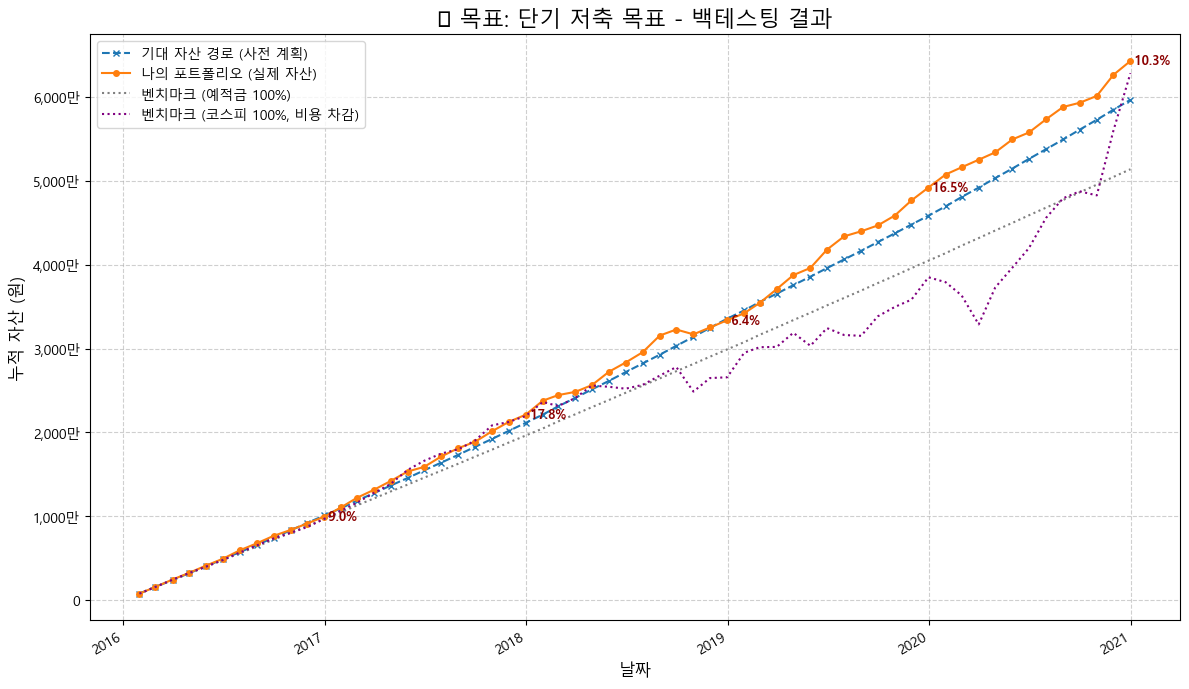

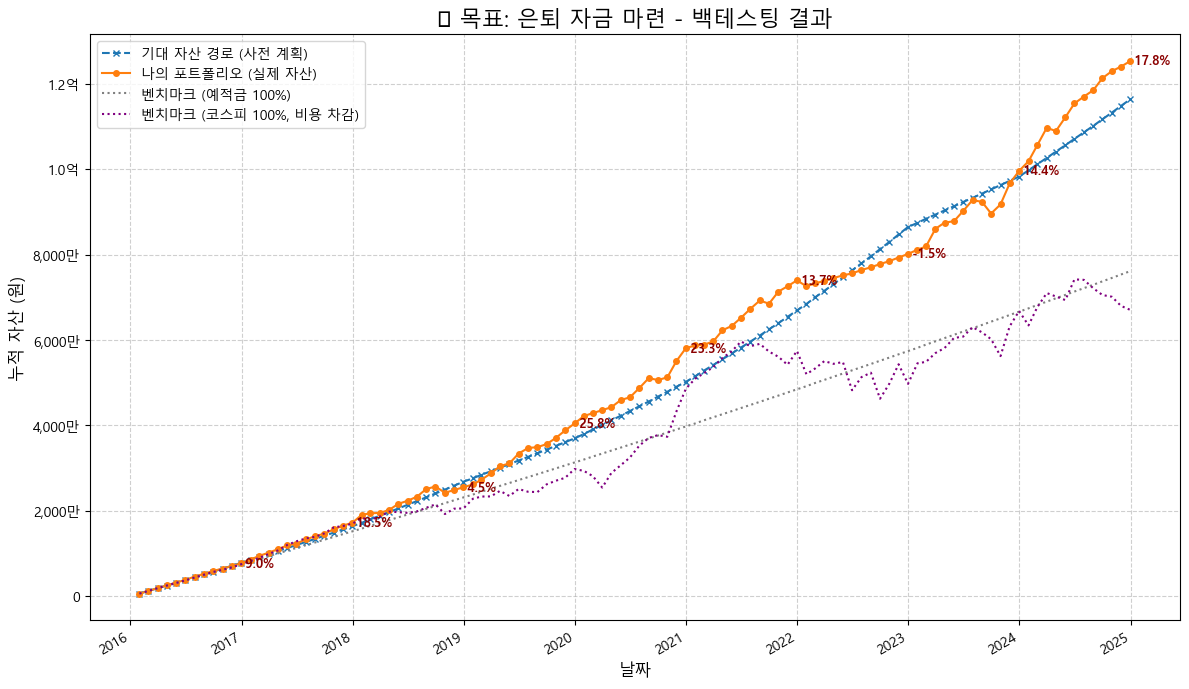

In [18]:
# ==============================================================================
# 섹션 1: 라이브러리, 헬퍼 함수, 시각화 함수 정의
# ==============================================================================
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import yfinance as yf
import warnings

# ✅ target=0(사실상 폐기된) 목표 제거
final_adjusted_goals = [g for g in final_adjusted_goals if g.get("target", 0) > 0]

# ✅ 이후 단계(백테스트/그래프)가 이 최종본만 보도록 확정
goal_list = [
    {
        "name": g["name"],
        "years": int(g["years"]),
        "target": int(g["target"]),
        "priority": int(g.get("priority", 99)),
        "necessity": g.get("necessity", "선택"),
    }
    for g in final_adjusted_goals
]

# (선택) 캐시에 최종본 저장해서 다음 실행 때도 일관되게 사용
with open("financial_goals_cache.json", "w", encoding="utf-8") as f:
    json.dump(goal_list, f, ensure_ascii=False, indent=4)


# --- 기본 설정 ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

# --- 필수 변수 정의 (이전 셀에서 생성되었다고 가정) ---
# df_returns_full, asset_names, df_merged, vol_limit_map, profile, goal_list 등이
df_returns_full = df_merged.pct_change().dropna()

# 이전에 정의되었다고 가정합니다.
asset_fees = {
    'KOSPI': 0.0015, 'KOSPI200': 0.000039, 'KOSDAQ': 0.0025,
    'S&P 500': 0.00006, '나스닥 100': 0.000062, 'CSI 300': 0.0049,
    '니케이 225': 0.0006, '유로스톡스50': 0.0030, 'GLD': 0.0029,
    'KRX 채권지수 국채 3M~1Y': 0.0015, 'KRX 채권지수 국채 2Y~3Y': 0.0015,
    'KRX 채권지수 국채 3Y~5Y': 0.0015, 'KRX 채권지수 국채 5Y~10Y': 0.0012,
    'KRX 채권지수 회사채 종합': 0.0015
}
fee_rates = np.array([asset_fees.get(name, 0) for name in asset_names])
slippage_rate = 0.0005

# --- 헬퍼 함수들 ---
def korean_currency_formatter(x, pos):
    if x >= 1e8: return f'{x / 1e8:,.1f}억'
    if x >= 1e4: return f'{x / 1e4:,.0f}만'
    return f'{x:,.0f}'

def get_unified_stock_limit(current_year_index, total_years):
    max_ratio, min_ratio = 0.9, 0.3
    glide_ratio = ((total_years-1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))

def calculate_monthly_investment(target_amount, yearly_return_rates):
    def simulate_fund(monthly_invest, rate_list):
        fund = 0
        for r in rate_list:
            for _ in range(12):
                fund = fund * (1 + r / 12) + monthly_invest
        return fund
    low, high = 0, 10_000_000
    while high - low > 1000:
        mid = (low + high) // 2
        if simulate_fund(mid, yearly_return_rates) > target_amount:
            high = mid
        else:
            low = mid
    return high

def generate_multifactor_signal(vix_data, market_df, vix_caution=23, vix_danger=30, ma_period=12):
    base_index = market_df.index
    vix_signal = pd.Series(0, index=base_index)
    if not vix_data.empty:
        vix_monthly_max = vix_data['Close'].resample('M').last().reindex(base_index, method='ffill').fillna(0)
        vix_signal[vix_monthly_max > vix_caution] = 1
        vix_signal[vix_monthly_max > vix_danger] = 2
    market_monthly_close = market_df['나스닥 100']
    ma_monthly = market_monthly_close.rolling(window=ma_period).mean()
    ma_signal = pd.Series(0, index=base_index)
    ma_signal[market_monthly_close < ma_monthly] = 2
    combined_signal = pd.DataFrame({'VIX': vix_signal.astype(int), 'MA': ma_signal.astype(int)}).max(axis=1)
    combined_signal.name = "RiskLevel"
    return combined_signal


# ==============================================================================
# ★★★ 백테스팅 함수 (기대 자산 항목 추가) ★★★
# ==============================================================================
def run_and_analyze_backtest_with_costs(goals, returns_df, risk_signal, fees, slippage):
    all_results_df = pd.DataFrame()
    goal_summary_list = []
    all_goal_details = {}

    n_assets = len(asset_names)
    is_stock = np.array([0 if '채권' in name else 1 for name in asset_names])
    target_vol = vol_limit_map[profile]
    kospi_fee_monthly = asset_fees.get('KOSPI', 0) / 12

    try:
        safe_asset_idx = next(i for i, name in enumerate(asset_names) if '채권' in name)
    except StopIteration:
        raise ValueError("asset_names 리스트에서 '채권'을 포함하는 자산을 찾을 수 없습니다.")
    safe_asset_weights = np.zeros(n_assets); safe_asset_weights[safe_asset_idx] = 1.0

    for goal in goals:
        goal_name, goal_years, target_amount = goal["name"], goal["years"], goal["target"]
        print(f"--- <{goal_name}> 목표 계산 및 백테스팅 진행 중 ---")

        yearly_expected_return, yearly_expected_vol, yearly_weights = [], [], []
        for year_idx in range(goal_years):
            train_end = pd.to_datetime('2015-12-31') + pd.DateOffset(years=year_idx)
            train_start = train_end - pd.DateOffset(years=10)
            train_returns = returns_df.loc[train_start:train_end]

            if train_returns.empty or len(train_returns) < 60:
                mu_train, cov_train, weights_opt = np.zeros(n_assets), np.zeros((n_assets, n_assets)), safe_asset_weights
            else:
                mu_train = train_returns.ewm(span=60).mean().iloc[-1].values * 12
                cov_train = train_returns.ewm(span=60).cov().iloc[-n_assets:].values * 12
                stock_limit = get_unified_stock_limit(year_idx, goal_years)
                w = cp.Variable(n_assets)
                constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov_train) <= target_vol**2, is_stock @ w <= stock_limit]
                prob = cp.Problem(cp.Maximize(mu_train @ w), constraints)
                prob.solve(solver=cp.SCS)
                weights_opt = w.value if (w.value is not None and prob.status == 'optimal') else safe_asset_weights

            yearly_expected_return.append(mu_train @ weights_opt)
            yearly_expected_vol.append(np.sqrt(weights_opt.T @ cov_train @ weights_opt))
            yearly_weights.append(weights_opt)

        monthly_investment = calculate_monthly_investment(target_amount, yearly_expected_return)
        goal_summary_list.append({"목표명": goal_name, "목표 기간 (년)": goal_years, "목표 금액 (원)": target_amount, "필요 월 저축액 (원)": monthly_investment, "연평균 기대수익률 (%)": np.mean(yearly_expected_return) * 100})

        backtest_start_date = pd.to_datetime('2016-01-31')
        actual_end_date = backtest_start_date + pd.DateOffset(years=goal_years) - pd.DateOffset(days=1)
        actual_returns = returns_df.loc[backtest_start_date : min(pd.to_datetime('2024-12-31'), actual_end_date)]
        
        path_data = []
        if not actual_returns.empty:
            fund_final, fund_savings, fund_kospi, fund_expected = 0, 0, 0, 0
            previous_weights = yearly_weights[0]
            for i, date in enumerate(actual_returns.index):
                year_idx = min(date.year - backtest_start_date.year, goal_years - 1)
                risk_level = risk_signal.get(date, 0)
                weights_tdf = yearly_weights[year_idx]
                
                weights_final = (weights_tdf * 0.5) + (safe_asset_weights * 0.5) if risk_level == 1 else safe_asset_weights if risk_level == 2 else weights_tdf
                
                turnover = np.sum(np.abs(weights_final - previous_weights)) / 2
                transaction_cost = (fund_final * turnover) * slippage_rate
                return_final = np.dot(actual_returns.loc[date].values, weights_final)
                fund_final = fund_final * (1 + return_final) + monthly_investment - transaction_cost
                
                expected_r, kospi_return = yearly_expected_return[year_idx], actual_returns.loc[date, 'KOSPI']
                fund_expected = fund_expected * (1 + expected_r / 12) + monthly_investment
                fund_savings = fund_savings * (1 + 0.03 / 12) + monthly_investment
                fund_kospi = fund_kospi * (1 + kospi_return) + monthly_investment - (fund_kospi * kospi_fee_monthly)

                path_data.append({'기간': date, '목표': goal_name, '월 투자금': monthly_investment, '실제 자산 (비용 차감)': fund_final, '기대 자산 (원)': fund_expected, '실제 자산 (예적금)': fund_savings, '실제 자산 (코스피, 비용 차감)': fund_kospi, '월별 실제수익률': return_final})
                previous_weights = weights_final

        monthly_summary_full = pd.DataFrame(path_data)
        if monthly_summary_full.empty: continue
        all_results_df = pd.concat([all_results_df, monthly_summary_full], ignore_index=True)
        
        monthly_summary = monthly_summary_full.set_index('기간')
        annual_perf_records = []
        yearly_summary = monthly_summary.resample('A').last()
        yearly_vols = monthly_summary['월별 실제수익률'].resample('A').std() * np.sqrt(12)

        previous_year_asset = 0
        for i, (year_end_date, row) in enumerate(yearly_summary.iterrows()):
            if i >= len(yearly_expected_return): break
            year = year_end_date.year
            current_year_months = monthly_summary.loc[str(year)].shape[0]
            cumulative_investment = monthly_investment * ((i * 12) + current_year_months)
            final_asset = row['실제 자산 (비용 차감)']
            principal_this_year = monthly_investment * current_year_months
            investment_gain = final_asset - previous_year_asset - principal_this_year
            denominator = previous_year_asset + (principal_this_year / 2)
            actual_annual_return = investment_gain / denominator if denominator != 0 else 0
            cumulative_return = (final_asset - cumulative_investment) / cumulative_investment if cumulative_investment > 0 else 0
            
            annual_perf_records.append({"연도": year, "기대수익률": yearly_expected_return[i], "기대변동성": yearly_expected_vol[i], "실제수익률": actual_annual_return, "실제변동성": yearly_vols.get(year_end_date, 0), "누적투자금": cumulative_investment, "기대자산": row['기대 자산 (원)'], "누적자산": final_asset, "누적수익률": cumulative_return})
            previous_year_asset = final_asset

        all_goal_details[goal_name] = {"performance": pd.DataFrame(annual_perf_records), "allocation": pd.DataFrame(yearly_weights[:len(annual_perf_records)], index=[r['연도'] for r in annual_perf_records], columns=asset_names)}
    return all_results_df, goal_summary_list, all_goal_details

# ==============================================================================
# ★★★ 상세 분석 표 출력 함수 (기대 자산 항목 추가) ★★★
# ==============================================================================
def display_detailed_analysis(all_goal_details):
    print("\n\n" + "="*80)
    print("### 🎯 목표별 상세 분석 결과 ###")
    print("="*80 + "\n")

    for goal_name, details in all_goal_details.items():
        print(f"\n--- 📊 목표: {goal_name} ---\n")
        print(" [ 연도별 성과 지표 ]")
        perf_df = details['performance']
        if not perf_df.empty:
            # ✅ 컬럼 순서 재정의 및 서식 추가
            column_order = ["연도", "기대수익률", "실제수익률", "기대변동성", "실제변동성", "누적투자금", "기대자산", "누적자산", "누적수익률"]
            perf_df = perf_df[column_order]
            display(perf_df.style.format({"연도": "{:d}", "기대수익률": "{:.2%}", "실제수익률": "{:.2%}", "기대변동성": "{:.2%}", "실제변동성": "{:.2%}", "누적투자금": "{:,.0f}원", "기대자산": "{:,.0f}원", "누적자산": "{:,.0f}원", "누적수익률": "{:.2%}"}).hide(axis="index"))
        else: print("  - 성과 데이터가 없습니다.")

        print("\n [ 연도별 자산 배분 (TDF 전략) ]")
        alloc_df = details['allocation']
        if not alloc_df.empty:
            alloc_to_display = alloc_df.loc[:, (alloc_df != 0).any(axis=0)]
            display(alloc_to_display.style.format("{:.1%}"))
        else: print("  - 자산 배분 데이터가 없습니다.")
        print("\n" + "-"*60)
        
# ==============================================================================
# ★★★ 시각화 함수 ★★★
# ==============================================================================
def plot_final_comparison_with_costs(df_comparison, goals):
    print("\n\n--- ### **최종 전략 및 벤치마크 비교 그래프 (수수료+슬리피지 반영)** ---\n")
    for goal in goals:
        goal_name = goal['name']
        is_short_term = goal.get("is_short_term", False)
        df_goal = df_comparison[df_comparison['목표'] == goal_name].copy()
        if df_goal.empty: continue
        
        df_goal['기간'] = pd.to_datetime(df_goal['기간'])
        df_goal_indexed = df_goal.set_index('기간')
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(df_goal_indexed.index, df_goal_indexed['기대 자산 (원)'], marker='x', linestyle='--', markersize=4, label="기대 자산 경로 (사전 계획)")
        ax.plot(df_goal_indexed.index, df_goal_indexed['실제 자산 (비용 차감)'], marker='o', markersize=4, label="나의 포트폴리오 (실제 자산)")
        if not is_short_term:
            ax.plot(df_goal_indexed.index, df_goal_indexed['실제 자산 (예적금)'], linestyle=':', color='gray', label="벤치마크 (예적금 100%)")
            ax.plot(df_goal_indexed.index, df_goal_indexed['실제 자산 (코스피, 비용 차감)'], linestyle=':', color='purple', label="벤치마크 (코스피 100%, 비용 차감)")

        yearly_assets = df_goal_indexed['실제 자산 (비용 차감)'].resample('Y').last()
        monthly_investment_for_goal = df_goal['월 투자금'].iloc[0]
        previous_year_asset = 0
        for date, end_of_year_asset in yearly_assets.items():
            current_year = date.year
            months_in_year = (df_goal_indexed.index.year == current_year).sum()
            principal_this_year = monthly_investment_for_goal * months_in_year
            investment_gain = end_of_year_asset - previous_year_asset - principal_this_year
            denominator = previous_year_asset + (principal_this_year / 2) if previous_year_asset > 0 else principal_this_year / 2
            annual_return = investment_gain / denominator if denominator != 0 else 0
            ax.text(date, end_of_year_asset, f' {annual_return:.1%}', ha='left', va='center', fontsize=9, color='darkred', fontweight='bold')
            previous_year_asset = end_of_year_asset

        ax.set_title(f"📈 목표: {goal_name} - 백테스팅 결과", fontsize=16)
        ax.set_xlabel("날짜", fontsize=12)
        ax.set_ylabel("누적 자산 (원)", fontsize=12)
        ax.yaxis.set_major_formatter(FuncFormatter(korean_currency_formatter))
        ax.legend(fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()

# ==============================================================================
# ★★★ 최종 실행부 ★★★
# ==============================================================================
try:
    vix_data_raw = yf.download('^VIX', start='2005-01-01', end='2024-12-31', progress=False)
    vix_daily = pd.DataFrame() if vix_data_raw.empty else vix_data_raw.droplevel(1, axis=1)[['Close']].copy() if isinstance(vix_data_raw.columns, pd.MultiIndex) else vix_data_raw[['Close']].copy()
except Exception as e:
    print(f"⚠️ VIX 지수 다운로드 중 오류 발생: {e}.")
    vix_daily = pd.DataFrame()

multifactor_signal_nasdaq = generate_multifactor_signal(vix_daily, df_merged)

if 'goal_list' in locals() and goal_list:
    final_comparison_for_plot, goal_summary_data, all_details = run_and_analyze_backtest_with_costs(goals=goal_list, returns_df=df_returns_full, risk_signal=multifactor_signal_nasdaq, fees=fee_rates, slippage=slippage_rate)
    display_detailed_analysis(all_details)
    plot_final_comparison_with_costs(final_comparison_for_plot, goal_list)
else:
    print("⚠️ 'goal_list'가 정의되지 않아 백테스팅을 실행할 수 없습니다.")

--- <단기 저축 목표> 목표 계산 및 백테스팅 진행 중 ---
--- <은퇴 자금 마련> 목표 계산 및 백테스팅 진행 중 ---


### 🎯 목표별 상세 분석 결과 ###


--- 📊 목표: 단기 저축 목표 ---

 [ 연도별 성과 지표 ]


연도,기대수익률,실제수익률,기대변동성,실제변동성,누적투자금,기대자산,누적자산,누적수익률
2016,12.51%,8.97%,10.00%,6.73%,"9,536,124원","10,102,134원","9,963,930원",4.49%
2017,9.97%,17.76%,9.62%,4.99%,"19,072,248원","21,140,428원","22,115,853원",15.96%
2018,10.77%,6.37%,6.87%,8.23%,"28,608,372원","33,555,413원","33,365,160원",16.63%
2019,7.02%,16.50%,6.15%,4.26%,"38,144,496원","45,835,891원","49,194,612원",28.97%
2020,8.21%,10.28%,4.57%,3.31%,"47,680,620원","59,649,719원","64,276,911원",34.81%



 [ 연도별 자산 배분 (TDF 전략) ]


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2016,0.0%,0.0%,0.0%,0.0%,58.8%,9.4%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,31.8%,0.0%
2017,-0.0%,-0.0%,-0.0%,-0.0%,66.0%,-0.0%,-0.0%,-0.0%,-0.0%,-0.0%,-0.0%,-0.0%,34.0%,-0.0%
2018,0.0%,0.0%,-0.0%,0.0%,54.0%,-0.0%,0.0%,0.0%,-0.0%,-0.0%,-0.0%,-0.0%,46.0%,-0.0%
2019,0.0%,0.0%,0.0%,0.0%,42.0%,0.0%,0.0%,0.0%,-0.0%,0.0%,0.0%,0.0%,58.0%,0.0%
2020,0.0%,0.0%,0.0%,0.0%,30.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,70.0%,0.0%



------------------------------------------------------------

--- 📊 목표: 은퇴 자금 마련 ---

 [ 연도별 성과 지표 ]


연도,기대수익률,실제수익률,기대변동성,실제변동성,누적투자금,기대자산,누적자산,누적수익률
2016,12.50%,8.97%,10.00%,6.73%,"7,382,808원","7,820,986원","7,713,950원",4.49%
2017,10.19%,18.55%,10.00%,5.12%,"14,765,616원","16,393,235원","17,212,306원",16.57%
2018,14.47%,4.47%,10.00%,13.65%,"22,148,424원","26,820,908원","25,530,073원",15.27%
2019,8.81%,25.85%,10.00%,6.36%,"29,531,232원","36,968,615원","40,466,337원",37.03%
2020,13.73%,23.29%,10.00%,8.27%,"36,914,040원","50,242,793원","58,134,723원",57.49%
2021,16.15%,13.72%,10.00%,5.47%,"44,296,848원","66,943,036원","73,999,878원",67.05%
2022,16.09%,-1.55%,10.00%,2.82%,"51,679,656원","86,500,825원","80,180,207원",55.15%
2023,4.83%,14.39%,10.00%,7.93%,"59,062,464원","98,319,756원","99,629,583원",68.69%
2024,10.09%,17.79%,10.00%,4.49%,"66,445,272원","116,451,298원","125,397,162원",88.72%



 [ 연도별 자산 배분 (TDF 전략) ]


,KOSPI,KOSPI200,KOSDAQ,S&P 500,나스닥 100,CSI 300,니케이 225,유로스톡스50,GLD,KRX 채권지수 국채 3M~1Y,KRX 채권지수 국채 2Y~3Y,KRX 채권지수 국채 3Y~5Y,KRX 채권지수 국채 5Y~10Y,KRX 채권지수 회사채 종합
2016,0.0%,0.0%,0.0%,0.0%,58.8%,9.4%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,31.8%,0.0%
2017,0.0%,0.0%,0.0%,-0.0%,67.6%,0.0%,1.3%,0.0%,-0.0%,-0.0%,-0.0%,-0.0%,31.0%,-0.0%
2018,-0.0%,-0.0%,8.3%,0.0%,74.0%,-0.0%,1.0%,0.0%,-0.0%,-0.0%,-0.0%,-0.0%,16.8%,-0.0%
2019,0.0%,0.0%,0.0%,0.0%,68.3%,0.0%,0.0%,0.0%,-0.0%,0.0%,0.0%,0.0%,31.7%,0.0%
2020,-0.0%,-0.0%,-0.0%,0.0%,66.0%,-0.0%,0.0%,0.0%,15.5%,0.0%,0.0%,0.0%,18.6%,0.0%
2021,0.0%,0.0%,0.0%,0.0%,48.3%,0.0%,0.0%,0.0%,17.9%,0.0%,0.0%,0.0%,33.9%,0.0%
2022,0.0%,0.0%,0.0%,0.0%,56.7%,0.0%,0.0%,0.0%,7.0%,0.0%,0.0%,36.3%,0.0%,0.0%
2023,-0.0%,-0.0%,-0.0%,41.9%,-0.0%,-0.0%,-0.0%,-0.0%,34.4%,23.7%,0.0%,0.0%,0.0%,0.0%
2024,0.0%,0.0%,0.0%,0.0%,29.3%,0.0%,17.2%,0.0%,26.8%,26.6%,0.0%,0.0%,0.0%,0.0%



------------------------------------------------------------


--- ### **최종 전략 및 벤치마크 비교 그래프 (수수료+슬리피지 반영)** ---



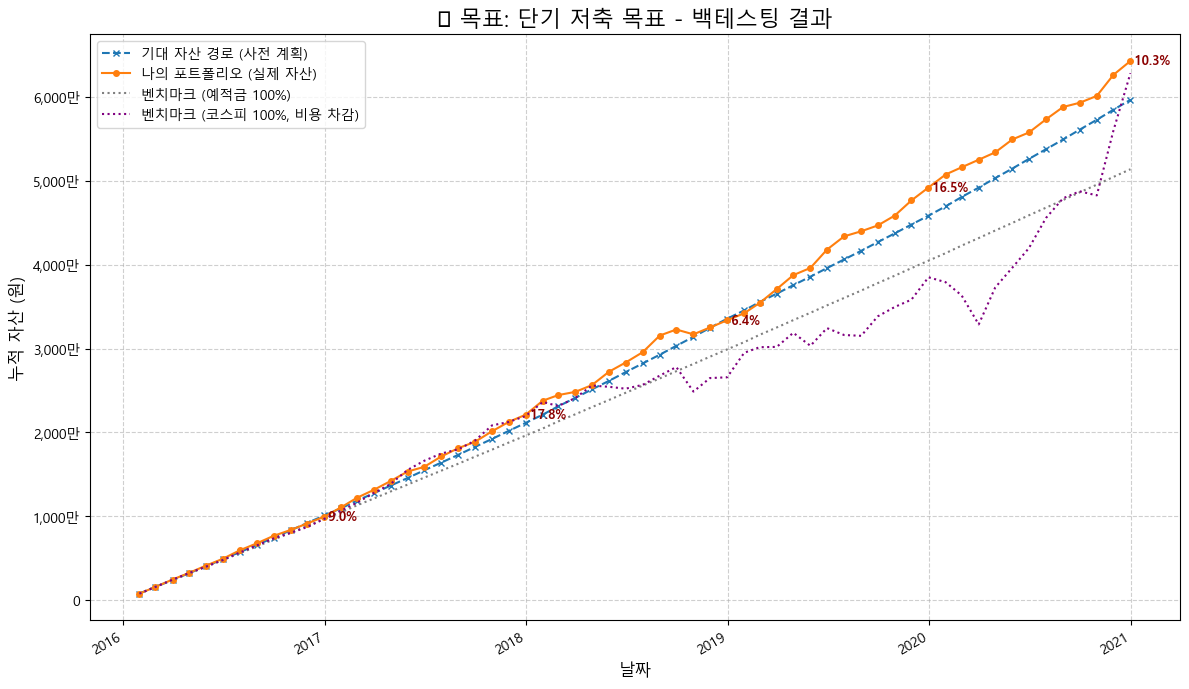

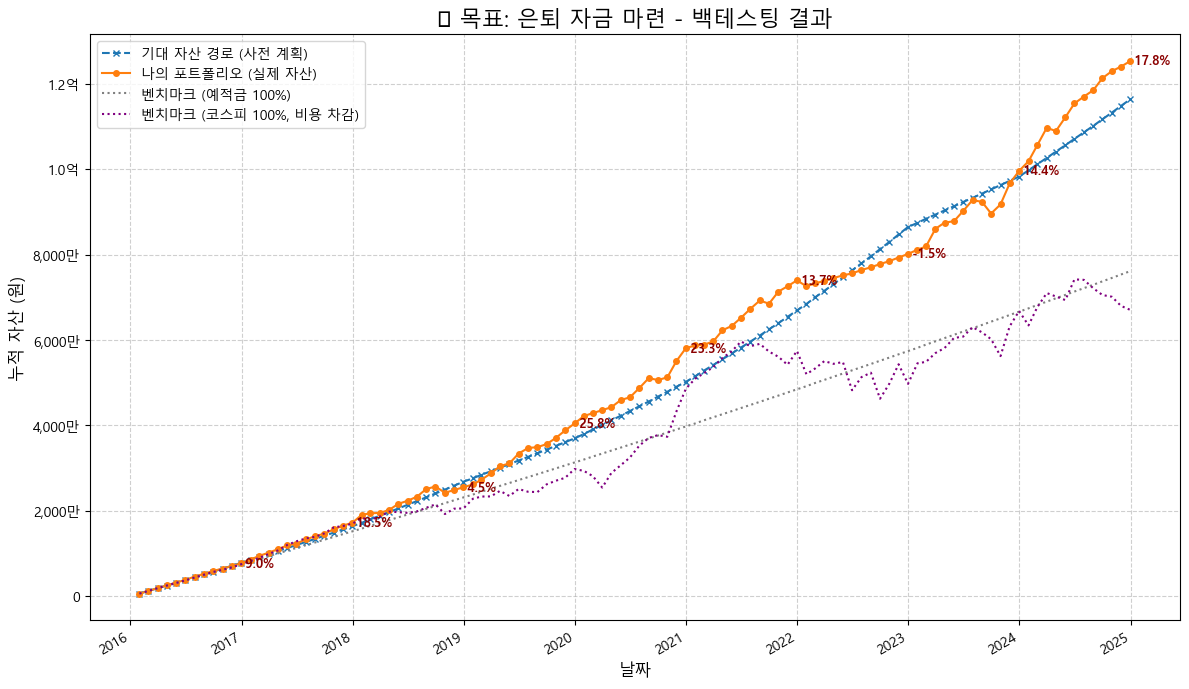


===== [단기 저축 목표] 포트폴리오 vs 나스닥100 =====
기간: 2016-01-31 ~ 2020-12-31
- CAGR    : PF 144.37% / NDX 25.14% / Δ 119.23%
- Vol(연) : PF 52.00%  / NDX 17.28%  / Δ 34.71%
- MDD     : PF -1.78%  / NDX -17.30%  / Δ 15.52%
- Sharpe  : PF 1.96 / NDX 1.39 / Δ 0.56
- 월간 초과수익 승률 : 76.27%


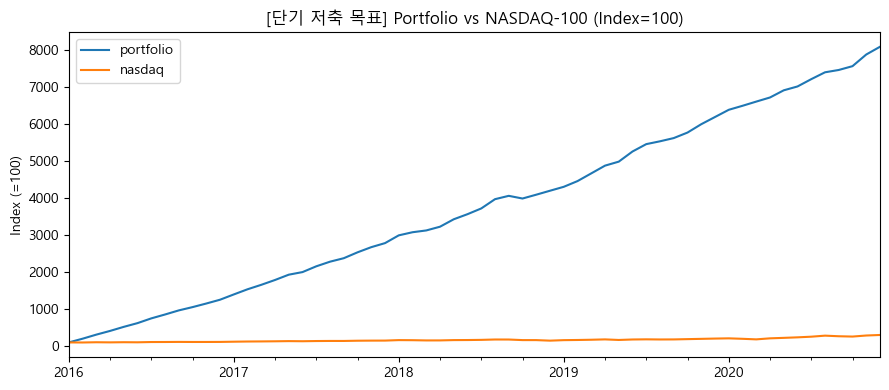


===== [은퇴 자금 마련] 포트폴리오 vs 나스닥100 =====
기간: 2016-01-31 ~ 2024-12-31
- CAGR    : PF 81.54% / NDX 19.54% / Δ 62.01%
- Vol(연) : PF 40.58%  / NDX 18.61%  / Δ 21.97%
- MDD     : PF -5.69%  / NDX -32.97%  / Δ 27.28%
- Sharpe  : PF 1.64 / NDX 1.06 / Δ 0.59
- 월간 초과수익 승률 : 71.03%


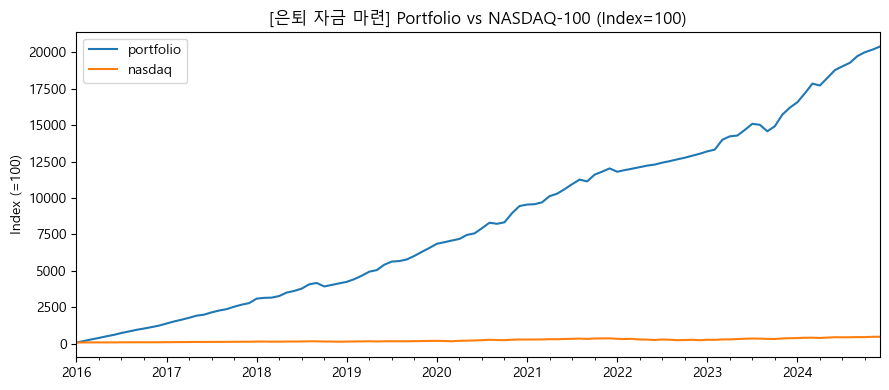

,목표,기간,PF_CAGR,NDX_CAGR,ΔCAGR,PF_Vol,NDX_Vol,ΔVol,PF_MDD,NDX_MDD,ΔMDD,PF_Sharpe,NDX_Sharpe,ΔSharpe,월간_초과수익_승률
0,단기 저축 목표,2016-01-31 ~ 2020-12-31,144.37%,25.14%,119.23%,52.00%,17.28%,34.71%,-1.78%,-17.30%,15.52%,1.96,1.39,0.56,76.27%
1,은퇴 자금 마련,2016-01-31 ~ 2024-12-31,81.54%,19.54%,62.01%,40.58%,18.61%,21.97%,-5.69%,-32.97%,27.28%,1.64,1.06,0.59,71.03%


In [23]:
# ==============================================================================
# 섹션 1: 라이브러리, 헬퍼 함수, 시각화 함수 정의
# ==============================================================================
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import yfinance as yf
import warnings
import json

# ✅ target=0(사실상 폐기된) 목표 제거
final_adjusted_goals = [g for g in final_adjusted_goals if g.get("target", 0) > 0]

# ✅ 이후 단계(백테스트/그래프)가 이 최종본만 보도록 확정
goal_list = [
    {
        "name": g["name"],
        "years": int(g["years"]),
        "target": int(g["target"]),
        "priority": int(g.get("priority", 99)),
        "necessity": g.get("necessity", "선택"),
    }
    for g in final_adjusted_goals
]

# (선택) 캐시에 최종본 저장해서 다음 실행 때도 일관되게 사용
with open("financial_goals_cache.json", "w", encoding="utf-8") as f:
    json.dump(goal_list, f, ensure_ascii=False, indent=4)

# --- 기본 설정 ---
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
# plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['axes.unicode_minus'] = False

# --- 필수 변수 정의 (이전 셀에서 생성되었다고 가정) ---
# df_returns_full, asset_names, df_merged, vol_limit_map, profile, goal_list 등이
df_returns_full = df_merged.pct_change().dropna()

# 이전에 정의되었다고 가정합니다.
asset_fees = {
    'KOSPI': 0.0015, 'KOSPI200': 0.000039, 'KOSDAQ': 0.0025,
    'S&P 500': 0.00006, '나스닥 100': 0.000062, 'CSI 300': 0.0049,
    '니케이 225': 0.0006, '유로스톡스50': 0.0030, 'GLD': 0.0029,
    'KRX 채권지수 국채 3M~1Y': 0.0015, 'KRX 채권지수 국채 2Y~3Y': 0.0015,
    'KRX 채권지수 국채 3Y~5Y': 0.0015, 'KRX 채권지수 국채 5Y~10Y': 0.0012,
    'KRX 채권지수 회사채 종합': 0.0015
}
fee_rates = np.array([asset_fees.get(name, 0) for name in asset_names])
slippage_rate = 0.0005

# --- 헬퍼 함수들 ---
def korean_currency_formatter(x, pos):
    if x >= 1e8: return f'{x / 1e8:,.1f}억'
    if x >= 1e4: return f'{x / 1e4:,.0f}만'
    return f'{x:,.0f}'

def get_unified_stock_limit(current_year_index, total_years):
    max_ratio, min_ratio = 0.9, 0.3
    glide_ratio = ((total_years-1) - current_year_index) / total_years if total_years > 0 else 0
    stock_ratio = min_ratio + (max_ratio - min_ratio) * glide_ratio
    return max(min_ratio, min(max_ratio, stock_ratio))

def calculate_monthly_investment(target_amount, yearly_return_rates):
    def simulate_fund(monthly_invest, rate_list):
        fund = 0
        for r in rate_list:
            for _ in range(12):
                fund = fund * (1 + r / 12) + monthly_invest
        return fund
    low, high = 0, 10_000_000
    while high - low > 1000:
        mid = (low + high) // 2
        if simulate_fund(mid, yearly_return_rates) > target_amount:
            high = mid
        else:
            low = mid
    return high

def generate_multifactor_signal(vix_data, market_df, vix_caution=23, vix_danger=30, ma_period=12):
    base_index = market_df.index
    vix_signal = pd.Series(0, index=base_index)
    if not vix_data.empty:
        vix_monthly_max = vix_data['Close'].resample('M').last().reindex(base_index, method='ffill').fillna(0)
        vix_signal[vix_monthly_max > vix_caution] = 1
        vix_signal[vix_monthly_max > vix_danger] = 2
    market_monthly_close = market_df['나스닥 100']
    ma_monthly = market_monthly_close.rolling(window=ma_period).mean()
    ma_signal = pd.Series(0, index=base_index)
    ma_signal[market_monthly_close < ma_monthly] = 2
    combined_signal = pd.DataFrame({'VIX': vix_signal.astype(int), 'MA': ma_signal.astype(int)}).max(axis=1)
    combined_signal.name = "RiskLevel"
    return combined_signal

# ======================================================================
# ✅ 나스닥(나스닥 100)과 비교 유틸 (내부 df_merged['나스닥 100'] 사용)
# ======================================================================

def fmt(x):
    return f"{x:.2f}" if pd.notna(x) else "-"
def _to_month_end(s: pd.Series) -> pd.Series:
    if not isinstance(s.index, pd.DatetimeIndex):
        s.index = pd.to_datetime(s.index)
    return s.resample('M').last()

def _norm100(s: pd.Series) -> pd.Series:
    s = s.dropna()
    return s / (s.iloc[0] if s.iloc[0] != 0 else 1) * 100.0

def _mdd(series100: pd.Series) -> float:
    roll_max = series100.cummax()
    dd = series100 / roll_max - 1.0
    return dd.min()  # 음수값

def _cagr(series100: pd.Series) -> float:
    s = series100.dropna()
    if len(s) < 2: return np.nan
    years = max(len(s)-1, 1) / 12.0  # 월말 기준
    return (s.iloc[-1] / s.iloc[0]) ** (1/years) - 1

def _ann_vol(mret: pd.Series) -> float:
    return mret.std(ddof=1) * np.sqrt(12)

def _sharpe(mret: pd.Series, rf_annual: float = 0.0) -> float:
    rf_m = (1 + rf_annual) ** (1/12) - 1
    excess = mret - rf_m
    vol = excess.std(ddof=1)
    return np.nan if vol == 0 or np.isnan(vol) else (excess.mean()*np.sqrt(12))/vol

def compare_vs_nasdaq_inline(portfolio_equity: pd.Series,
                             nasdaq_price: pd.Series,
                             start: str, end: str,
                             rf_annual: float = 0.0):
    # 월말 정렬 & 기간 슬라이싱
    p = _to_month_end(portfolio_equity).loc[start:end].dropna()
    n = _to_month_end(nasdaq_price).loc[start:end].dropna()

    # 지수=100 정규화
    p100 = _norm100(p).rename('portfolio')
    n100 = _norm100(n).rename('nasdaq')
    aligned = pd.concat([p100, n100], axis=1).dropna()

    mret = aligned.pct_change().dropna()
    pr, nr = mret['portfolio'], mret['nasdaq']

    report = {
        "period": f"{aligned.index.min().date()} ~ {aligned.index.max().date()}",
        "portfolio": {"CAGR": _cagr(p100), "Vol": _ann_vol(pr), "MDD": _mdd(p100), "Sharpe": _sharpe(pr, rf_annual)},
        "nasdaq":    {"CAGR": _cagr(n100), "Vol": _ann_vol(nr), "MDD": _mdd(n100), "Sharpe": _sharpe(nr, rf_annual)},
        "diff": {},
        "win_rate_over_nasdaq_m": float((pr - nr > 0).sum())/len(mret) if len(mret)>0 else np.nan
    }
    report["diff"] = {
        "CAGR": report["portfolio"]["CAGR"] - report["nasdaq"]["CAGR"],
        "Vol":  report["portfolio"]["Vol"]  - report["nasdaq"]["Vol"],
        "MDD":  report["portfolio"]["MDD"]  - report["nasdaq"]["MDD"],
        "Sharpe": (report["portfolio"]["Sharpe"] - report["nasdaq"]["Sharpe"]
                   if (pd.notna(report["portfolio"]["Sharpe"]) and pd.notna(report["nasdaq"]["Sharpe"])) else np.nan)
    }
    return report, aligned

# ==============================================================================
# ★★★ 백테스팅 함수 (기대 자산 항목 추가) ★★★
# ==============================================================================
def run_and_analyze_backtest_with_costs(goals, returns_df, risk_signal, fees, slippage):
    all_results_df = pd.DataFrame()
    goal_summary_list = []
    all_goal_details = {}

    n_assets = len(asset_names)
    is_stock = np.array([0 if '채권' in name else 1 for name in asset_names])
    target_vol = vol_limit_map[profile]
    kospi_fee_monthly = asset_fees.get('KOSPI', 0) / 12

    try:
        safe_asset_idx = next(i for i, name in enumerate(asset_names) if '채권' in name)
    except StopIteration:
        raise ValueError("asset_names 리스트에서 '채권'을 포함하는 자산을 찾을 수 없습니다.")
    safe_asset_weights = np.zeros(n_assets); safe_asset_weights[safe_asset_idx] = 1.0

    for goal in goals:
        goal_name, goal_years, target_amount = goal["name"], goal["years"], goal["target"]
        print(f"--- <{goal_name}> 목표 계산 및 백테스팅 진행 중 ---")

        yearly_expected_return, yearly_expected_vol, yearly_weights = [], [], []
        for year_idx in range(goal_years):
            train_end = pd.to_datetime('2015-12-31') + pd.DateOffset(years=year_idx)
            train_start = train_end - pd.DateOffset(years=10)
            train_returns = returns_df.loc[train_start:train_end]

            if train_returns.empty or len(train_returns) < 60:
                mu_train, cov_train, weights_opt = np.zeros(n_assets), np.zeros((n_assets, n_assets)), safe_asset_weights
            else:
                mu_train = train_returns.ewm(span=60).mean().iloc[-1].values * 12
                cov_train = train_returns.ewm(span=60).cov().iloc[-n_assets:].values * 12
                stock_limit = get_unified_stock_limit(year_idx, goal_years)
                w = cp.Variable(n_assets)
                constraints = [cp.sum(w) == 1, w >= 0, cp.quad_form(w, cov_train) <= target_vol**2, is_stock @ w <= stock_limit]
                prob = cp.Problem(cp.Maximize(mu_train @ w), constraints)
                prob.solve(solver=cp.SCS)
                weights_opt = w.value if (w.value is not None and prob.status == 'optimal') else safe_asset_weights

            yearly_expected_return.append(mu_train @ weights_opt)
            yearly_expected_vol.append(np.sqrt(weights_opt.T @ cov_train @ weights_opt))
            yearly_weights.append(weights_opt)

        monthly_investment = calculate_monthly_investment(target_amount, yearly_expected_return)
        goal_summary_list.append({
            "목표명": goal_name, "목표 기간 (년)": goal_years, "목표 금액 (원)": target_amount,
            "필요 월 저축액 (원)": monthly_investment, "연평균 기대수익률 (%)": np.mean(yearly_expected_return) * 100
        })

        backtest_start_date = pd.to_datetime('2016-01-31')
        actual_end_date = backtest_start_date + pd.DateOffset(years=goal_years) - pd.DateOffset(days=1)
        actual_returns = returns_df.loc[backtest_start_date : min(pd.to_datetime('2024-12-31'), actual_end_date)]
        
        path_data = []
        if not actual_returns.empty:
            fund_final, fund_savings, fund_kospi, fund_expected = 0, 0, 0, 0
            previous_weights = yearly_weights[0]
            for i, date in enumerate(actual_returns.index):
                year_idx = min(date.year - backtest_start_date.year, goal_years - 1)
                risk_level = risk_signal.get(date, 0)
                weights_tdf = yearly_weights[year_idx]
                
                weights_final = (weights_tdf * 0.5) + (safe_asset_weights * 0.5) if risk_level == 1 else safe_asset_weights if risk_level == 2 else weights_tdf
                
                turnover = np.sum(np.abs(weights_final - previous_weights)) / 2
                transaction_cost = (fund_final * turnover) * slippage_rate
                return_final = np.dot(actual_returns.loc[date].values, weights_final)
                fund_final = fund_final * (1 + return_final) + monthly_investment - transaction_cost
                
                expected_r, kospi_return = yearly_expected_return[year_idx], actual_returns.loc[date, 'KOSPI']
                fund_expected = fund_expected * (1 + expected_r / 12) + monthly_investment
                fund_savings = fund_savings * (1 + 0.03 / 12) + monthly_investment
                fund_kospi = fund_kospi * (1 + kospi_return) + monthly_investment - (fund_kospi * kospi_fee_monthly)

                path_data.append({
                    '기간': date, '목표': goal_name, '월 투자금': monthly_investment,
                    '실제 자산 (비용 차감)': fund_final,
                    '기대 자산 (원)': fund_expected,
                    '실제 자산 (예적금)': fund_savings,
                    '실제 자산 (코스피, 비용 차감)': fund_kospi,
                    '월별 실제수익률': return_final
                })
                previous_weights = weights_final

        monthly_summary_full = pd.DataFrame(path_data)
        if monthly_summary_full.empty: continue
        all_results_df = pd.concat([all_results_df, monthly_summary_full], ignore_index=True)
        
        monthly_summary = monthly_summary_full.set_index('기간')
        annual_perf_records = []
        yearly_summary = monthly_summary.resample('A').last()
        yearly_vols = monthly_summary['월별 실제수익률'].resample('A').std() * np.sqrt(12)

        previous_year_asset = 0
        for i, (year_end_date, row) in enumerate(yearly_summary.iterrows()):
            if i >= len(yearly_expected_return): break
            year = year_end_date.year
            current_year_months = monthly_summary.loc[str(year)].shape[0]
            cumulative_investment = monthly_investment * ((i * 12) + current_year_months)
            final_asset = row['실제 자산 (비용 차감)']
            principal_this_year = monthly_investment * current_year_months
            investment_gain = final_asset - previous_year_asset - principal_this_year
            denominator = previous_year_asset + (principal_this_year / 2)
            actual_annual_return = investment_gain / denominator if denominator != 0 else 0
            cumulative_return = (final_asset - cumulative_investment) / cumulative_investment if cumulative_investment > 0 else 0
            
            annual_perf_records.append({
                "연도": year, "기대수익률": yearly_expected_return[i], "기대변동성": yearly_expected_vol[i],
                "실제수익률": actual_annual_return, "실제변동성": yearly_vols.get(year_end_date, 0),
                "누적투자금": cumulative_investment, "기대자산": row['기대 자산 (원)'],
                "누적자산": final_asset, "누적수익률": cumulative_return
            })
            previous_year_asset = final_asset

        all_goal_details[goal_name] = {
            "performance": pd.DataFrame(annual_perf_records),
            "allocation": pd.DataFrame(yearly_weights[:len(annual_perf_records)],
                                       index=[r['연도'] for r in annual_perf_records],
                                       columns=asset_names)
        }
    return all_results_df, goal_summary_list, all_goal_details

# ==============================================================================
# ★★★ 상세 분석 표 출력 함수 (기대 자산 항목 추가) ★★★
# ==============================================================================
def display_detailed_analysis(all_goal_details):
    print("\n\n" + "="*80)
    print("### 🎯 목표별 상세 분석 결과 ###")
    print("="*80 + "\n")

    for goal_name, details in all_goal_details.items():
        print(f"\n--- 📊 목표: {goal_name} ---\n")
        print(" [ 연도별 성과 지표 ]")
        perf_df = details['performance']
        if not perf_df.empty:
            # ✅ 컬럼 순서 재정의 및 서식 추가
            column_order = ["연도", "기대수익률", "실제수익률", "기대변동성", "실제변동성",
                            "누적투자금", "기대자산", "누적자산", "누적수익률"]
            perf_df = perf_df[column_order]
            display(perf_df.style.format({
                "연도": "{:d}", "기대수익률": "{:.2%}", "실제수익률": "{:.2%}",
                "기대변동성": "{:.2%}", "실제변동성": "{:.2%}",
                "누적투자금": "{:,.0f}원", "기대자산": "{:,.0f}원",
                "누적자산": "{:,.0f}원", "누적수익률": "{:.2%}"
            }).hide(axis="index"))
        else:
            print("  - 성과 데이터가 없습니다.")

        print("\n [ 연도별 자산 배분 (TDF 전략) ]")
        alloc_df = details['allocation']
        if not alloc_df.empty:
            alloc_to_display = alloc_df.loc[:, (alloc_df != 0).any(axis=0)]
            display(alloc_to_display.style.format("{:.1%}"))
        else:
            print("  - 자산 배분 데이터가 없습니다.")
        print("\n" + "-"*60)

# ==============================================================================
# ★★★ 시각화 함수 ★★★
# ==============================================================================
def plot_final_comparison_with_costs(df_comparison, goals):
    print("\n\n--- ### **최종 전략 및 벤치마크 비교 그래프 (수수료+슬리피지 반영)** ---\n")
    for goal in goals:
        goal_name = goal['name']
        is_short_term = goal.get("is_short_term", False)
        df_goal = df_comparison[df_comparison['목표'] == goal_name].copy()
        if df_goal.empty: continue
        
        df_goal['기간'] = pd.to_datetime(df_goal['기간'])
        df_goal_indexed = df_goal.set_index('기간')
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(df_goal_indexed.index, df_goal_indexed['기대 자산 (원)'], marker='x',
                linestyle='--', markersize=4, label="기대 자산 경로 (사전 계획)")
        ax.plot(df_goal_indexed.index, df_goal_indexed['실제 자산 (비용 차감)'], marker='o',
                markersize=4, label="나의 포트폴리오 (실제 자산)")
        if not is_short_term:
            ax.plot(df_goal_indexed.index, df_goal_indexed['실제 자산 (예적금)'],
                    linestyle=':', color='gray', label="벤치마크 (예적금 100%)")
            ax.plot(df_goal_indexed.index, df_goal_indexed['실제 자산 (코스피, 비용 차감)'],
                    linestyle=':', color='purple', label="벤치마크 (코스피 100%, 비용 차감)")

        yearly_assets = df_goal_indexed['실제 자산 (비용 차감)'].resample('Y').last()
        monthly_investment_for_goal = df_goal['월 투자금'].iloc[0]
        previous_year_asset = 0
        for date, end_of_year_asset in yearly_assets.items():
            current_year = date.year
            months_in_year = (df_goal_indexed.index.year == current_year).sum()
            principal_this_year = monthly_investment_for_goal * months_in_year
            investment_gain = end_of_year_asset - previous_year_asset - principal_this_year
            denominator = previous_year_asset + (principal_this_year / 2) if previous_year_asset > 0 else principal_this_year / 2
            annual_return = investment_gain / denominator if denominator != 0 else 0
            ax.text(date, end_of_year_asset, f' {annual_return:.1%}', ha='left', va='center', fontsize=9, color='darkred', fontweight='bold')
            previous_year_asset = end_of_year_asset

        ax.set_title(f"📈 목표: {goal_name} - 백테스팅 결과", fontsize=16)
        ax.set_xlabel("날짜", fontsize=12)
        ax.set_ylabel("누적 자산 (원)", fontsize=12)
        ax.yaxis.set_major_formatter(FuncFormatter(korean_currency_formatter))
        ax.legend(fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        fig.autofmt_xdate()
        plt.tight_layout()
        plt.show()

# ==============================================================================
# ★★★ 최종 실행부 ★★★
# ==============================================================================
try:
    vix_data_raw = yf.download('^VIX', start='2005-01-01', end='2024-12-31', progress=False)
    vix_daily = pd.DataFrame() if vix_data_raw.empty else (
        vix_data_raw.droplevel(1, axis=1)[['Close']].copy()
        if isinstance(vix_data_raw.columns, pd.MultiIndex) else vix_data_raw[['Close']].copy()
    )
except Exception as e:
    print(f"⚠️ VIX 지수 다운로드 중 오류 발생: {e}.")
    vix_daily = pd.DataFrame()

    


multifactor_signal_nasdaq = generate_multifactor_signal(vix_daily, df_merged)

if 'goal_list' in locals() and goal_list:
    # 1) 백테스트 실행 및 기존 리포트/그래프
    final_comparison_for_plot, goal_summary_data, all_details = run_and_analyze_backtest_with_costs(
        goals=goal_list, returns_df=df_returns_full, risk_signal=multifactor_signal_nasdaq,
        fees=fee_rates, slippage=slippage_rate
    )
    display_detailed_analysis(all_details)
    plot_final_comparison_with_costs(final_comparison_for_plot, goal_list)

    # 2) ✅ 나스닥(나스닥 100)과 목표별 정량 비교(동일 기간/월말/Index=100) + 그래프
    assert '나스닥 100' in df_merged.columns, "'나스닥 100' 컬럼이 df_merged에 필요합니다."
    nasdaq_px = df_merged['나스닥 100'].copy()

    all_reports = []
    for g in goal_list:
        goal_name = g['name']
        df_goal = final_comparison_for_plot[final_comparison_for_plot['목표'] == goal_name].copy()
        if df_goal.empty:
            print(f"[건너뜀] 목표 '{goal_name}' 데이터가 없습니다.")
            continue

        s_port = df_goal.set_index('기간')['실제 자산 (비용 차감)'].sort_index()
        s_port.index = pd.to_datetime(s_port.index)

        start = s_port.index.min().strftime("%Y-%m-%d")
        end   = s_port.index.max().strftime("%Y-%m-%d")

        rep, aligned100 = compare_vs_nasdaq_inline(
            portfolio_equity=s_port,
            nasdaq_price=nasdaq_px,
            start=start, end=end,
            rf_annual=0.0
        )

        # 콘솔 요약
        def pct(x): return "-" if pd.isna(x) else f"{x*100:.2f}%"
        print(f"\n===== [{goal_name}] 포트폴리오 vs 나스닥100 =====")
        print(f"기간: {rep['period']}")
        print(f"- CAGR    : PF {pct(rep['portfolio']['CAGR'])} / NDX {pct(rep['nasdaq']['CAGR'])} / Δ {pct(rep['diff']['CAGR'])}")
        print(f"- Vol(연) : PF {pct(rep['portfolio']['Vol'])}  / NDX {pct(rep['nasdaq']['Vol'])}  / Δ {pct(rep['diff']['Vol'])}")
        print(f"- MDD     : PF {pct(rep['portfolio']['MDD'])}  / NDX {pct(rep['nasdaq']['MDD'])}  / Δ {pct(rep['diff']['MDD'])}")
        sh_pf = rep['portfolio']['Sharpe']; sh_ndx = rep['nasdaq']['Sharpe']; sh_d = rep['diff']['Sharpe']


        print(f"- Sharpe  : PF {fmt(sh_pf)} / NDX {fmt(sh_ndx)} / Δ {fmt(sh_d)}")

        print(f"- 월간 초과수익 승률 : {pct(rep['win_rate_over_nasdaq_m'])}")

        # 지수=100 그래프
        ax = aligned100.plot(figsize=(9,4), title=f"[{goal_name}] Portfolio vs NASDAQ-100 (Index=100)")
        ax.set_ylabel("Index (=100)")
        plt.tight_layout(); plt.show()

        # 요약 테이블 행
        all_reports.append({
            "목표": goal_name, "기간": rep["period"],
            "PF_CAGR": rep["portfolio"]["CAGR"], "NDX_CAGR": rep["nasdaq"]["CAGR"], "ΔCAGR": rep["diff"]["CAGR"],
            "PF_Vol":  rep["portfolio"]["Vol"],  "NDX_Vol":  rep["nasdaq"]["Vol"],  "ΔVol":  rep["diff"]["Vol"],
            "PF_MDD":  rep["portfolio"]["MDD"],  "NDX_MDD":  rep["nasdaq"]["MDD"],  "ΔMDD":  rep["diff"]["MDD"],
            "PF_Sharpe": rep["portfolio"]["Sharpe"], "NDX_Sharpe": rep["nasdaq"]["Sharpe"], "ΔSharpe": rep["diff"]["Sharpe"],
            "월간_초과수익_승률": rep["win_rate_over_nasdaq_m"],
        })

    # 표로 보기(노트북에서 이쁘게) + (선택) 저장
    if all_reports:
        df_ndx_report = pd.DataFrame(all_reports)
        display(df_ndx_report.style.format({
            "PF_CAGR":"{:.2%}","NDX_CAGR":"{:.2%}","ΔCAGR":"{:.2%}",
            "PF_Vol":"{:.2%}","NDX_Vol":"{:.2%}","ΔVol":"{:.2%}",
            "PF_MDD":"{:.2%}","NDX_MDD":"{:.2%}","ΔMDD":"{:.2%}",
            "PF_Sharpe":"{:.2f}","NDX_Sharpe":"{:.2f}","ΔSharpe":"{:.2f}",
            "월간_초과수익_승률":"{:.2%}",
        }))
        # df_ndx_report.to_csv("portfolio_vs_nasdaq_summary.csv", index=False, encoding="utf-8-sig")

else:
    print("⚠️ 'goal_list'가 정의되지 않아 백테스팅을 실행할 수 없습니다.")


## 5. 가계부 분석 및 평가 AI 모델

In [ ]:
# -*- coding: utf-8 -*-
"""
Financial Report Prompt Runner (fixed)
- Reads `client_profile` (global or client_profile.json)
- Builds analysis prompt identical to the assistant's earlier format
- Calls OpenAI Chat Completions (optional)
"""

import os
import json
import re
from datetime import datetime

# -----------------------------
# Utilities
# -----------------------------

# NumPy/Pandas 객체를 파이썬 내장형으로 변환
def _to_builtin(obj):
    try:
        import numpy as np
    except Exception:
        class _DummyNP: pass
        np = _DummyNP()
        np.integer = ()
        np.floating = ()
        np.ndarray = ()
    try:
        import pandas as pd
    except Exception:
        pd = None

    # 원시형
    if obj is None or isinstance(obj, (str, int, float, bool)):
        return obj

    # NumPy 스칼라
    if hasattr(np, 'integer') and isinstance(obj, np.integer):
        return int(obj)
    if hasattr(np, 'floating') and isinstance(obj, np.floating):
        return float(obj)

    # Pandas Timestamp/NaT
    if pd is not None:
        if isinstance(obj, getattr(pd, 'Timestamp', ())):
            return obj.isoformat()
        if obj is getattr(pd, 'NaT', None):
            return None

    # datetime
    from datetime import datetime, date
    if isinstance(obj, (datetime, date)):
        return obj.isoformat()

    # dict
    if isinstance(obj, dict):
        return {str(_to_builtin(k)): _to_builtin(v) for k, v in obj.items()}

    # list/tuple/set
    if isinstance(obj, (list, tuple, set)):
        return [_to_builtin(v) for v in obj]

    # NumPy 배열
    if hasattr(np, 'ndarray') and isinstance(obj, np.ndarray):
        return [_to_builtin(v) for v in obj.tolist()]

    # 그 외: 문자열로
    return str(obj)


def _to_int_safe(x):
    """금액 문자열/정수/실수 -> 정수. None/빈문자열은 0."""
    if x is None:
        return 0
    if isinstance(x, (int, float)):
        return int(x)
    s = str(x)
    s = re.sub(r"[^\d\-.]", "", s)  # 숫자/마이너스/소수점 외 제거
    if s.strip() == "" or s == "-":
        return 0
    try:
        return int(float(s))
    except (ValueError, TypeError):
        return 0

def analyze_income_vs_expense_enhanced_fixed(client_profile):
    """최근 3개월 평균 수입/지출/저축/여윳돈 요약"""
    summary = client_profile.get('수입/지출/투자 현황', {})
    avg_income = _to_int_safe(summary.get('최근 3개월 평균 수입', 0))
    avg_expense = _to_int_safe(summary.get('최근 3개월 평균 지출', 0))
    avg_investment = _to_int_safe(summary.get('최근 3개월 평균 저축/투자', 0))
    avg_cash_surplus = _to_int_safe(summary.get('최근 3개월 평균 현금(여윳돈)', 0))
    total_savings = avg_cash_surplus + avg_investment
    savings_rate = (total_savings / avg_income) * 100 if avg_income > 0 else 0
    return {
        "평균 월 수입": avg_income,
        "평균 월 지출": avg_expense,
        "평균 월 저축/투자": avg_investment,
        "평균 월 현금(여윳돈)": avg_cash_surplus,
        "총 저축액 (저축/투자 + 여윳돈)": total_savings,
        "평균 저축률(%)": savings_rate
    }

def _sum_liquid_assets(client_profile):
    """유동성 자산(자유입출금 계정 등) 합산"""
    assets_block = client_profile.get('자산/부채 현황', {})
    if not assets_block:
        assets_block = {"자산 상세": client_profile.get('자산 상세', {})}
    detail = assets_block.get('자산 상세', {})
    dd = detail.get('자유입출금 자산', {})
    return sum(_to_int_safe(v) for v in dd.values())

def _get_baseline_numbers(client_profile):
    """보고서 머리말용 핵심 수치"""
    info = client_profile.get('고객정보', {})
    age = info.get('나이', None)
    job = info.get('직업', '')
    credit = info.get('신용점수', None)

    assets_block = client_profile.get('자산/부채 현황', {})
    total_assets = assets_block.get('총자산')
    total_debts = assets_block.get('총부채')
    net_assets = assets_block.get('순자산')

    summary = client_profile.get('수입/지출/투자 현황', {})
    avg_income = _to_int_safe(summary.get('최근 3개월 평균 수입', 0))
    avg_expense = _to_int_safe(summary.get('최근 3개월 평균 지출', 0))
    avg_invest = _to_int_safe(summary.get('최근 3개월 평균 저축/투자', 0))
    avg_surplus = _to_int_safe(summary.get('최근 3개월 평균 현금(여윳돈)', 0))

    return {
        "age": age, "job": job, "credit": credit,
        "total_assets": total_assets, "total_debts": total_debts, "net_assets": net_assets,
        "avg_income": avg_income, "avg_expense": avg_expense, "avg_invest": avg_invest, "avg_surplus": avg_surplus
    }

def _format_won(x):
    try:
        return f"{int(x):,}원"
    except Exception:
        return str(x)

def build_financial_report_prompt(client_profile: dict) -> str:
    """보고서 프롬프트 자동 생성"""
    기준월 = client_profile.get('수입/지출/투자 현황', {}).get('분석 기준월', 'YYYY-MM')
    데이터최근일 = client_profile.get('데이터 최근 날짜', client_profile.get('알림: 데이터의 최근 날짜', ''))

    head = _get_baseline_numbers(client_profile)
    liq = _sum_liquid_assets(client_profile)

    summary_calc = analyze_income_vs_expense_enhanced_fixed(client_profile)
    emergency_months = (liq / summary_calc["평균 월 지출"]) if summary_calc["평균 월 지출"] > 0 else 0.0

    header_human_context = f"""
고객 개요(요약):
- 나이/직업: {head['age']}세, {head['job']}
- 신용점수: {head['credit']}
- 총자산: {_format_won(head['total_assets'])}
- 총부채: {_format_won(head['total_debts'])}
- 순자산: {_format_won(head['net_assets'])}
- 최근 3개월 평균 수입: {_format_won(head['avg_income'])}
- 최근 3개월 평균 지출: {_format_won(head['avg_expense'])}
- 최근 3개월 평균 저축/투자: {_format_won(head['avg_invest'])}
- 최근 3개월 평균 여윳돈: {_format_won(head['avg_surplus'])}
- 추정 비상자금(유동성 자산): {_format_won(liq)} ≈ 월지출 {emergency_months:.1f}개월치
- 분석 기준월: {기준월} / 데이터 최근일: {데이터최근일}
""".strip()

    instruction = f"""
당신은 한국의 재무설계 전문가입니다.
다음 고객 데이터를 기반으로 통계청 KOSIS 가계금융복지조사, 한국FP협회 재무건전성 지표,
가계 예산 황금비율(50/30/20 또는 45/35/20)을 활용하여 고객의 재무상태를 종합 분석·평가하는 보고서를 작성하세요.

[분석 프로세스]
1) 고객 기본 정보 요약
   - 나이, 직업, 성별, 신용점수, 총자산, 총부채, 순자산, 자산 구성비(현금성/저축성/투자성)
2) 연령대 평균 대비 평가(통계청 2023, 30대 평균치 활용)
   - 총자산/부채/순자산/월평균 소득 비교 표 제시
   - '상위권/평균/하위권' 라벨링
3) 현금흐름 분석(최근 3개월 평균)
   - 수입/지출/저축·투자/여윳돈
   - FP협회 지표 계산 및 판정:
     · 가계수지비율(지출/수입 ≤ 80%)
     · 비상자금비율(유동자산/월지출 ≥ 3–6개월)
     · 총저축성향(저축액/수입 ≥ 30%)
     · 금융자산비중(≥ 40%)
     · 총부채부담비율(≤ 40%)
   - 판정은 '매우 우수/우수/양호/보완 필요/미흡' 중 하나로
4) 지출 구조 분석(기준월)
   - 고정비/변동비/저축 비율 산출 → 황금비율(45/35/20 또는 50/30/20)과 비교
   - 과다 비중 항목 및 개선 가능성 서술 (그 이유를 함께 자세히 설명)
5) 개선 방향 제안(구체적 실행 방안) -> 제안 이유를 자세히 설명
   - 저축률 상향(목표 % 및 금액), 비상자금 확충(목표 개월수와 경로),
     포트폴리오 다각화(배당/성장/채권/해외 분산), 절세계좌(연금저축·IRP) 활용,
     소득 다변화 아이디어
6) 종합 평가(한 문단 요약)
   - 강점/리스크/우선순위 정리
   - 결론부는 인용구 형태(> …)로 제시

[출력 형식]
- 섹션별 소제목 포함
- 표와 불릿포인트 활용
- 수치는 ‘원’ 단위로 표기
- 결론부 인용구 형식으로 강조

[참고: 사람이 미리 계산한 보조 요약]
{header_human_context}

[고객 데이터(JSON)]
{json.dumps(_to_builtin(client_profile), ensure_ascii=False, indent=2)}

""".strip()

    return instruction

# -----------------------------
# Runner
# -----------------------------

def load_client_profile_if_available():
    """
    1) 전역변수 client_profile 사용
    2) 없으면 ./client_profile.json 로드
    """
    try:
        if 'client_profile' in globals() and isinstance(globals()['client_profile'], dict):
            return globals()['client_profile']
    except Exception:
        pass

    try:
        for cand in ['client_profile.json', './client_profile.json']:
            if os.path.exists(cand):
                with open(cand, 'r', encoding='utf-8') as f:
                    return json.load(f)
    except Exception:
        pass

    return None

def main():
    cp = load_client_profile_if_available()
    if cp is None:
        print("[경고] client_profile 변수를 찾지 못했고 client_profile.json 파일도 없습니다.")
        print(" - 주피터/스크립트에서 `client_profile` 딕셔너리를 먼저 정의하거나,")
        print(" - 같은 폴더에 client_profile.json 파일을 두고 다시 실행하세요.")
        return

    prompt_text = build_financial_report_prompt(cp)

    # 결과 출력
    print("\n================= 모델 보고서 프롬프트 (복사해서 모델에 입력) =================\n")
    print(prompt_text)

    # 파일 저장
    out_path = "generated_prompt.txt"
    with open(out_path, "w", encoding="utf-8") as f:
        f.write(prompt_text)
    print(f"\n[안내] 프롬프트를 '{out_path}'로 저장했습니다.")

    # -------------------
    # (선택) OpenAI 호출 예시
    # -------------------
    # 보안상, API 키는 환경변수 OPENAI_API_KEY 로 주입하세요.
    # export OPENAI_API_KEY="YOUR_KEY"
    api_key = os.getenv("OPENAI_API_KEY")
    if not api_key:
        print("\n[참고] OPENAI_API_KEY 환경변수가 없어 API 호출을 건너뜁니다.")
        return

    try:
        from openai import OpenAI
        client = OpenAI(api_key=api_key)

        completion = client.chat.completions.create(
            model="gpt-4o-mini",  # 필요시 모델 변경 가능 (예: gpt-5-mini)
            messages=[{"role": "user", "content": prompt_text}]
        )
        print("\n================= 모델 응답 =================\n")
        print(completion.choices[0].message.content)
    except Exception as e:
        print(f"\n[오류] OpenAI 호출 중 문제가 발생했습니다: {e}")
        print(" - 모델 이름/버전 또는 SDK 버전을 확인하세요.")
        print(" - OPENAI_API_KEY가 유효한지 확인하세요.")

if __name__ == "__main__":
    main()



================= 모델 보고서 프롬프트 (복사해서 모델에 입력) =================

당신은 한국의 재무설계 전문가입니다.
다음 고객 데이터를 기반으로 통계청 KOSIS 가계금융복지조사, 한국FP협회 재무건전성 지표,
가계 예산 황금비율(50/30/20 또는 45/35/20)을 활용하여 고객의 재무상태를 종합 분석·평가하는 보고서를 작성하세요.

[분석 프로세스]
1) 고객 기본 정보 요약
   - 나이, 직업, 성별, 신용점수, 총자산, 총부채, 순자산, 자산 구성비(현금성/저축성/투자성)
2) 연령대 평균 대비 평가(통계청 2023, 30대 평균치 활용)
   - 총자산/부채/순자산/월평균 소득 비교 표 제시
   - '상위권/평균/하위권' 라벨링
3) 현금흐름 분석(최근 3개월 평균)
   - 수입/지출/저축·투자/여윳돈
   - FP협회 지표 계산 및 판정:
     · 가계수지비율(지출/수입 ≤ 80%)
     · 비상자금비율(유동자산/월지출 ≥ 3–6개월)
     · 총저축성향(저축액/수입 ≥ 30%)
     · 금융자산비중(≥ 40%)
     · 총부채부담비율(≤ 40%)
   - 판정은 '매우 우수/우수/양호/보완 필요/미흡' 중 하나로
4) 지출 구조 분석(기준월)
   - 고정비/변동비/저축 비율 산출 → 황금비율(45/35/20 또는 50/30/20)과 비교
   - 과다 비중 항목 및 개선 가능성 서술
5) 개선 방향 제안(구체적 실행 방안)
   - 저축률 상향(목표 % 및 금액), 비상자금 확충(목표 개월수와 경로),
     포트폴리오 다각화(배당/성장/채권/해외 분산), 절세계좌(연금저축·IRP) 활용,
     소득 다변화 아이디어
6) 종합 평가(한 문단 요약)
   - 강점/리스크/우선순위 정리
   - 결론부는 인용구 형태(> …)로 제시

[출력 형식]
- 섹션별 소제목 포함
- 표와 불릿포인트 활용
- 수치는 ‘원’ 단위로 표기
- 결론부 인용구 형식으로 강조

[참고: 사람이 미리 계

In [ ]:
import pandas as pd
import re

# ==============================================================================
# 🚀 최종 결과 요약 실행
# 이 코드는 이전 노트북 셀들이 모두 실행되어, 최종 변수들이
# 메모리에 이미 존재한다고 가정하고 해당 변수들을 직접 참조하여 요약합니다.
# ==============================================================================

try:
    # 1️⃣ 단계: 고객의 현재 프로필 요약
    print("--- 1. 고객 프로필 요약 ---")
    cp_info = client_profile.get("고객정보", {})
    cp_assets = client_profile.get("자산/부채 현황", {})
    cp_cashflow = client_profile.get("수입/지출/투자 현황", {})
    
    # '현금' 키 유무에 따라 유연하게 값을 가져오도록 수정
    avg_surplus = cp_cashflow.get('최근 3개월 평균 현금(여윳돈)', cp_cashflow.get('최근 3개월 평균 여윳돈', 'N/A'))

    print(f"  - 고객명: {cp_info.get('고객명', 'N/A')}")
    print(f"  - 나이/직업: {cp_info.get('나이', 'N/A')}세 / {cp_info.get('직업', 'N/A')}")
    print(f"  - 순자산: {cp_assets.get('순자산', 'N/A')}")
    print(f"  - 3개월 평균 월 여윳돈: {avg_surplus}")
    print("-" * 25)

    # 2️⃣ 단계: 가계부 분석 및 평가 (AI 모델 응답 결과)
    print("\n--- 2. 가계부 분석 및 평가 ---")
    # 마지막 셀의 모델 응답 결과 텍스트를 변수로 저장하여 출력
    financial_report_text = """

# 재무상태 종합 분석 보고서

## 1) 고객 기본 정보 요약
- **이름**: 넉넉한 윤리쌤
- **나이**: 30세
- **직업**: 공무원
- **성별**: 남
- **신용점수**: 934
- **총자산**: 37,189,716원
- **총부채**: 0원
- **순자산**: 37,189,716원
- **자산 구성비**:
  - 현금성 자산: 2,500,000원 (6.71%)
  - 저축성 자산: 13,440,000원 (36.1%)
  - 투자성 자산: 21,249,716원 (57.19%)

## 2) 연령대 평균 대비 평가
| 항목         | 고객 데이터         | 30대 평균치         | 평가          |
|--------------|---------------------|---------------------|---------------|
| 총자산      | 37,189,716 원       | 50,000,000 원       | 하위권        |
| 총부채      | 0 원                | 15,000,000 원       | 상위권        |
| 순자산      | 37,189,716 원       | 35,000,000 원       | 상위권        |
| 월평균 소득  | 4,751,009 원        | 4,500,000 원        | 상위권        |

## 3) 현금흐름 분석 (최근 3개월 평균)
- **수입**: 4,751,009 원
- **지출**: 3,138,115 원
- **저축·투자**: 800,000 원
- **여윳돈**: 812,893 원

### FP협회 지표 판정
- **가계수지비율**: 66% (양호)
- **비상자금비율**: 0.5개월 (미흡)
- **총저축성향**: 16.8% (보완 필요)
- **금융자산비중**: 57.19% (매우 우수)
- **총부채부담비율**: 0% (매우 우수)

## 4) 지출 구조 분석 (기준월: 2025-05)
| 항목           | 금액 (원)       | 비율      |
|----------------|------------------|-----------|
| 고정비         | 1,020,000        | 42.05%    |
| 변동비         | 1,409,616        | 57.95%    |
| 저축 비율      | 800,000          | 20%       |

**황금비율(50/30/20) 비교**:
- 고정비: 42.05% (양호)
- 변동비: 57.95% (과다)
- 저축 비율: 20% (보완 필요)

### 과다 비중 항목 및 개선 가능성
- **변동비**가 57.95%로 과다함. 특히 **온라인쇼핑**(490,826원)과 **식비**(153,459원)에서 절감 가능성이 있음.

## 5) 개선 방향 제안
1. **저축률 상향**: 목표 30% (1,425,000원)
2. **비상자금 확충**: 3개월 목표 (9,414,345원) - 소득의 일부를 비상자금으로 재배정.
3. **포트폴리오 다각화**:
   - 안정적인 **채권**이나 **배당주** 비율을 늘려 리스크 분산.
   - 지리적 다각화를 위해 해외주식 비중을 30%로 평준화.
4. **절세계좌 활용**:
   - 연금저축계좌 활용으로 절세 혜택.
5. **소득 다변화 아이디어**:
   - 프리랜서 업무 또는 블로그/유튜브 콘텐츠 제작을 통한 추가 수입 발생.

## 6) 종합 평가
고객님의 강점은 높은 신용점수와 무부채 상태에 있으나, 변동비 지출이 과다하여 저축 비율이 낮아 개선의 필요성이 큽니다. 재무구조에 안정성을 더하기 위해 비상금 확충과 저축률 개선이 최우선 과제로 제시됩니다.
"""
    print(financial_report_text)
    print("-" * 25)
    
    # 3️⃣ 단계: 최종 조정된 재무목표 요약
    print("\n--- 3. 손PB 재무목표 요약 ---")
    # 이전 셀에서 자동 조정 후 생성된 최종 결과인 'final_adjusted_goals' 변수를 직접 사용합니다.
    final_goal_summary = pd.DataFrame(final_adjusted_goals)[['name', 'years', 'target']]
    final_goal_summary.columns = ['목표명', '기간(년)', '총 목표 금액(원)']
    
    print(final_goal_summary.to_string(index=False, formatters={'총 목표 금액(원)': '{:,.0f}'.format}))
    print("-" * 25)

    # 4️⃣ 단계: 월별 투자 플랜 요약
    print("\n--- 4. 월별 투자 플랜 요약 ---")
    
    # 이전 셀에서 계산된 최종 월 투자금('total_required_final')을 사용합니다.
    # 이전 셀에서 계산된 첫 해 자산 배분 비중('yearly_opt_weights[0]')을 사용합니다.
    print(f"\n[ 월별 총 투자금액 ]")
    print(f"  - 최종 목표 달성을 위해 매월 약 {total_required_final:,.0f}원의 투자가 필요합니다.")

    first_year_weights = yearly_opt_weights[0]

    allocation_plan = pd.DataFrame({
        '자산명': asset_names,
        '비중': first_year_weights * 100,
        '월 투자금': first_year_weights * total_required_final
    })
    allocation_plan = allocation_plan[allocation_plan['비중'] > 0.1].sort_values('비중', ascending=False)
    
    print("\n[ 첫 해 월별 투자 플랜 (자산 배분) ]")
    print(allocation_plan.to_string(index=False, formatters={'비중': '{:,.2f}%'.format, '월 투자금': '{:,.0f}원'.format}))

except NameError as e:
    print(f"\n⚠️ 오류: '{e.name}' 변수가 정의되지 않았습니다.")
    print("이 코드를 실행하기 전에, 노트북의 이전 셀들을 모두 실행하여 필요한 변수들이 생성되었는지 확인해주세요.")
    print("필요 변수 예: client_profile, final_adjusted_goals, total_required_final, yearly_opt_weights 등")
except Exception as e:
    print(f"\n⚠️ 예상치 못한 오류가 발생했습니다: {e}")

--- 1. 고객 프로필 요약 ---
  - 고객명: 넉넉한 윤리쌤
  - 나이/직업: 30세 / 공무원
  - 순자산: 37189716.79104324
  - 3개월 평균 월 여윳돈: 812,893원
-------------------------

--- 2. 가계부 분석 및 평가 ---


# 재무상태 종합 분석 보고서

## 1) 고객 기본 정보 요약
- **이름**: 넉넉한 윤리쌤
- **나이**: 30세
- **직업**: 공무원
- **성별**: 남
- **신용점수**: 934
- **총자산**: 37,189,716원
- **총부채**: 0원
- **순자산**: 37,189,716원
- **자산 구성비**:
  - 현금성 자산: 2,500,000원 (6.71%)
  - 저축성 자산: 13,440,000원 (36.1%)
  - 투자성 자산: 21,249,716원 (57.19%)

## 2) 연령대 평균 대비 평가
| 항목         | 고객 데이터         | 30대 평균치         | 평가          |
|--------------|---------------------|---------------------|---------------|
| 총자산      | 37,189,716 원       | 50,000,000 원       | 하위권        |
| 총부채      | 0 원                | 15,000,000 원       | 상위권        |
| 순자산      | 37,189,716 원       | 35,000,000 원       | 상위권        |
| 월평균 소득  | 4,751,009 원        | 4,500,000 원        | 상위권        |

## 3) 현금흐름 분석 (최근 3개월 평균)
- **수입**: 4,751,009 원
- **지출**: 3,138,115 원
- **저축·투자**: 800,000 원
- **여윳돈**: 812,893 원

### FP협